# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [431]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
import math
warnings.filterwarnings(action="ignore")

import matplotlib.pyplot as plt
import seaborn as sns

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [434]:
# Importing the file porter_data_1.csv
df = pd.read_csv("porter_data_1.csv")

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [439]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df["created_at"] = pd.to_datetime(df["created_at"])
df["actual_delivery_time"] = pd.to_datetime(df["actual_delivery_time"])

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [442]:
# Convert categorical features to category type
df['store_primary_category'] = df['store_primary_category'].astype('category')
df['order_protocol'] = df['order_protocol'].astype('category')

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [446]:
# Calculate time taken in minutes
df['time_taken_minutes'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [449]:
# Extract the hour and day of week from the 'created_at' timestamp
df['hour'] = df['created_at'].dt.hour

# Extract day of week number (0 = Monday, 6 = Sunday)
df['day_of_week'] = df['created_at'].dt.dayofweek

# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Convert categorical features to category type
df['day_of_week'] = df['day_of_week'].astype('category')
df['isWeekend'] = df['isWeekend'].astype('category')
df['market_id'] = df['market_id'].astype('category')

In [451]:
# Drop unnecessary columns

# Dropping 'store_primary_category' as it has 73 unique categories.
# One-hot encoding it would create 73 dummy variables, leading to:
# - High model complexity (increased risk of overfitting)
# - Potential multicollinearity (high correlation among dummy variables)
# Therefore, dropping it to simplify the model and improve generalization.

df.drop(columns=['created_at', 'actual_delivery_time', 'store_primary_category'], inplace=True)

In [453]:
# Checking negative values in numerical columns
columns_to_check = ["total_items", "subtotal", "num_distinct_items", "min_item_price", "max_item_price", "total_onshift_dashers", "total_busy_dashers",
                    "total_outstanding_orders", "distance", "time_taken_minutes"]

negative_percentage = (df[columns_to_check] < 0).sum() / len(df[columns_to_check]) * 100
print(negative_percentage)

cols_with_negatives = [
    'min_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders'
]
df = df[(df[cols_with_negatives] >= 0).all(axis=1)]

total_items                 0.000000
subtotal                    0.000000
num_distinct_items          0.000000
min_item_price              0.006827
max_item_price              0.000000
total_onshift_dashers       0.011947
total_busy_dashers          0.011947
total_outstanding_orders    0.023325
distance                    0.000000
time_taken_minutes          0.000000
dtype: float64


Negative values were found in a few features (min_item_price, total_onshift_dashers, total_busy_dashers, and total_outstanding_orders) with a very small percentage of entries (less than 0.03%). Since the proportion of negative entries is extremely low, these rows have been removed to maintain data quality without significantly impacting the dataset size.

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [458]:
# Define target variable (y) and features (X)
y = df['time_taken_minutes']
X = df.drop(columns=['time_taken_minutes'])

# Check shapes
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (175687, 14)
Shape of y: (175687,)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [461]:
# Split data into training and testing sets

from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check the shapes of the split data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (140549, 14)
X_test shape: (35138, 14)
y_train shape: (140549,)
y_test shape: (35138,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [465]:
# Numerical columns
numerical_cols = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'distance'
]

# Categorical columns
categorical_cols = [
    'market_id',
    'order_protocol',
    'day_of_week',
    'isWeekend',
    'hour'
]

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

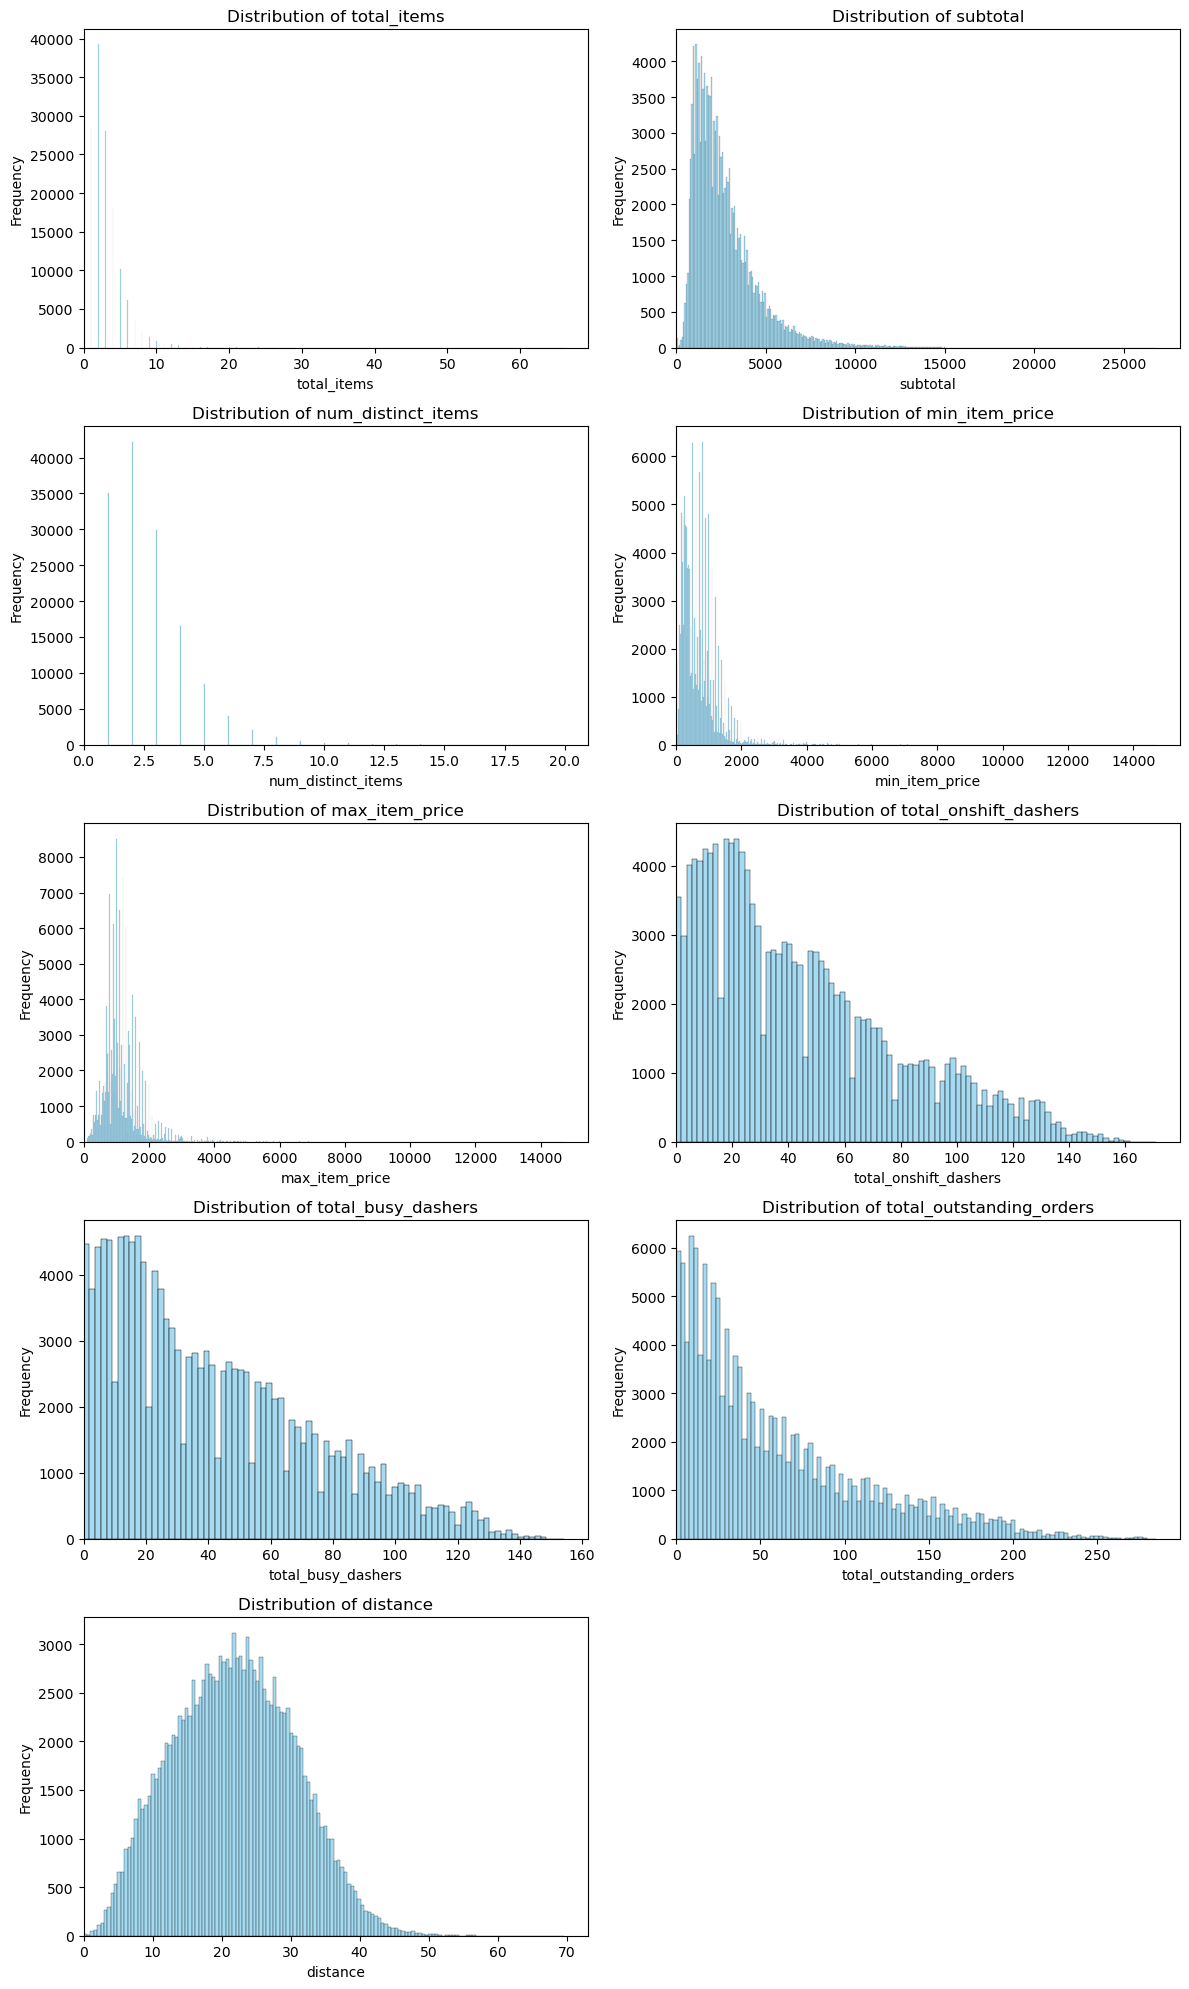

In [468]:
# Plot distributions for all numerical columns

n_cols = 2  # Number of columns per row in subplot grid
n_rows = math.ceil(len(numerical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()  # Flatten to 1D for easy indexing

for i, col in enumerate(numerical_cols):
    sns.histplot(X_train[col], color='skyblue', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(left=0)

# If number of plots < total subplots, remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

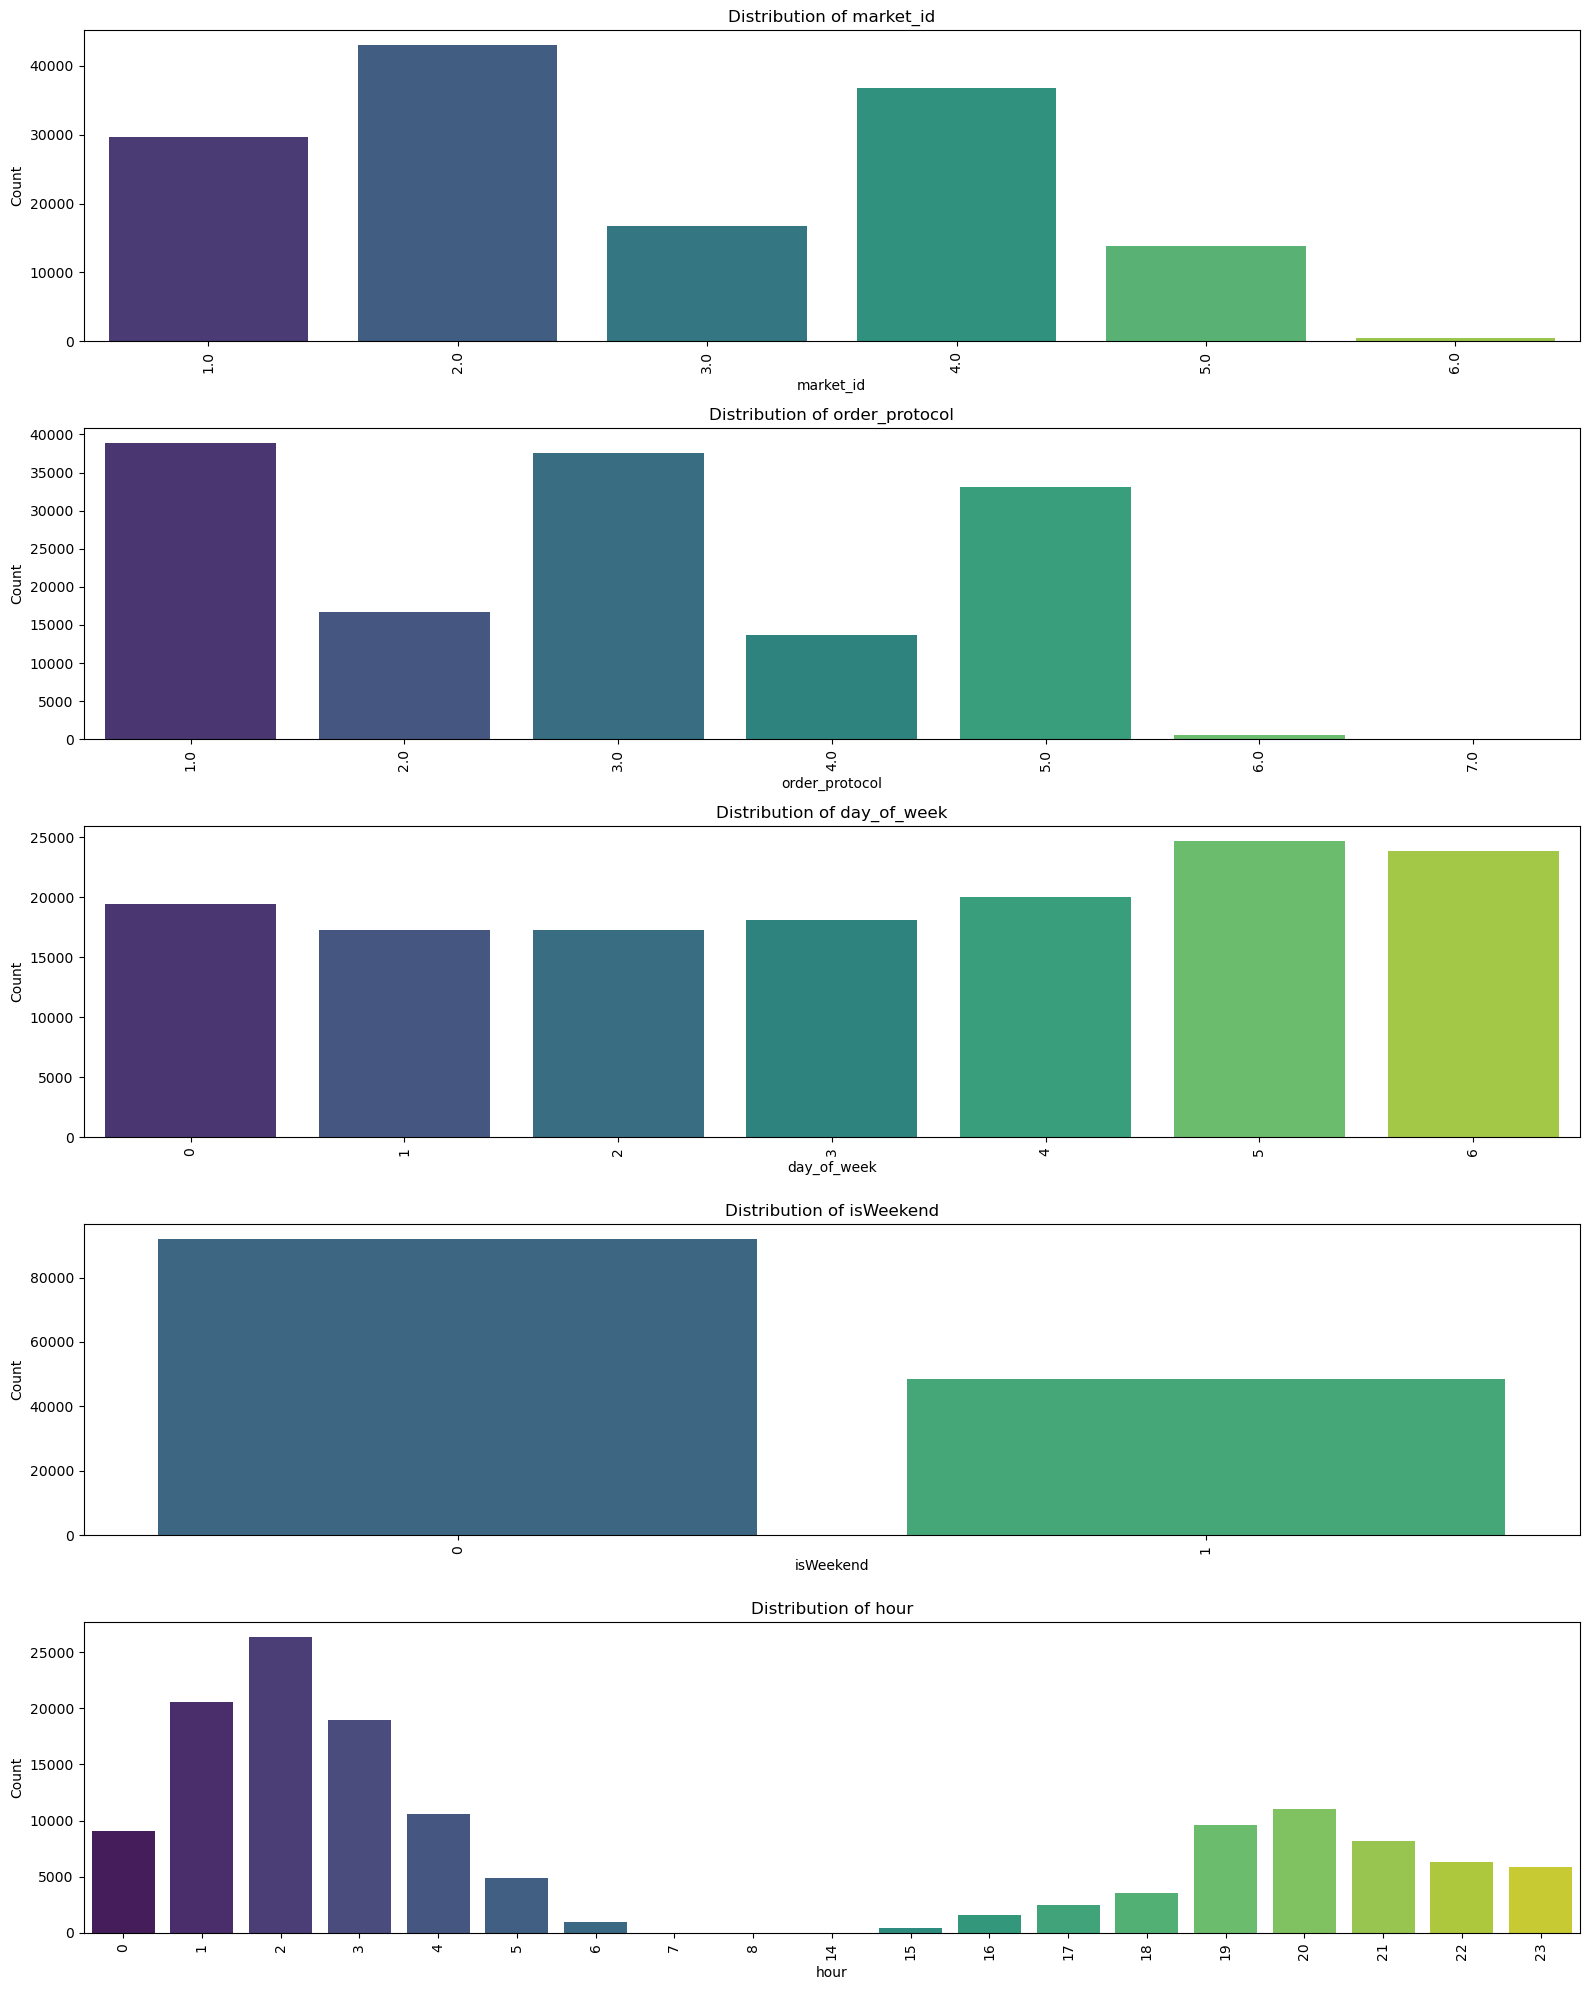

In [470]:
# Distribution of categorical columns
cat_features = len(categorical_cols)

# Set up a grid of subplots
plt.figure(figsize=(16, 4 * cat_features))

# Loop through each categorical column and plot
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(cat_features, 1, i)
    sns.countplot(x=X_train[col], palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

After analyzing the day_of_week categorical variable, it was observed that the variation in demand across different days was minimal. The existing is_weekend feature already captures the key distinction between weekdays and weekends. Retaining day_of_week would introduce six additional dummy variables, increasing model complexity without providing meaningful improvement in predictive power. Therefore, day_of_week was dropped to maintain a more efficient and interpretable model.

In [472]:
X_train = X_train.drop(columns=["day_of_week"])
X_test = X_test.drop(columns=["day_of_week"])
categorical_cols.remove("day_of_week")

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

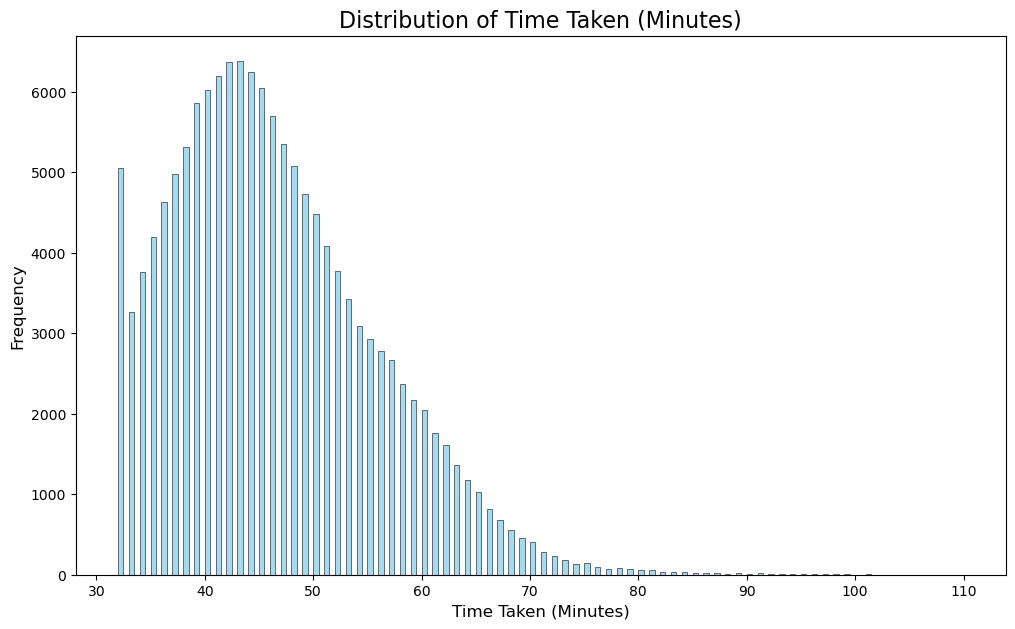

In [475]:
# Distribution of time_taken

# Plot the histogram for the target variable (time_taken_minutes)
plt.figure(figsize=(12, 7))
sns.histplot(y_train, color='skyblue')

# Add title and labels
plt.title('Distribution of Time Taken (Minutes)', fontsize=16)
plt.xlabel('Time Taken (Minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

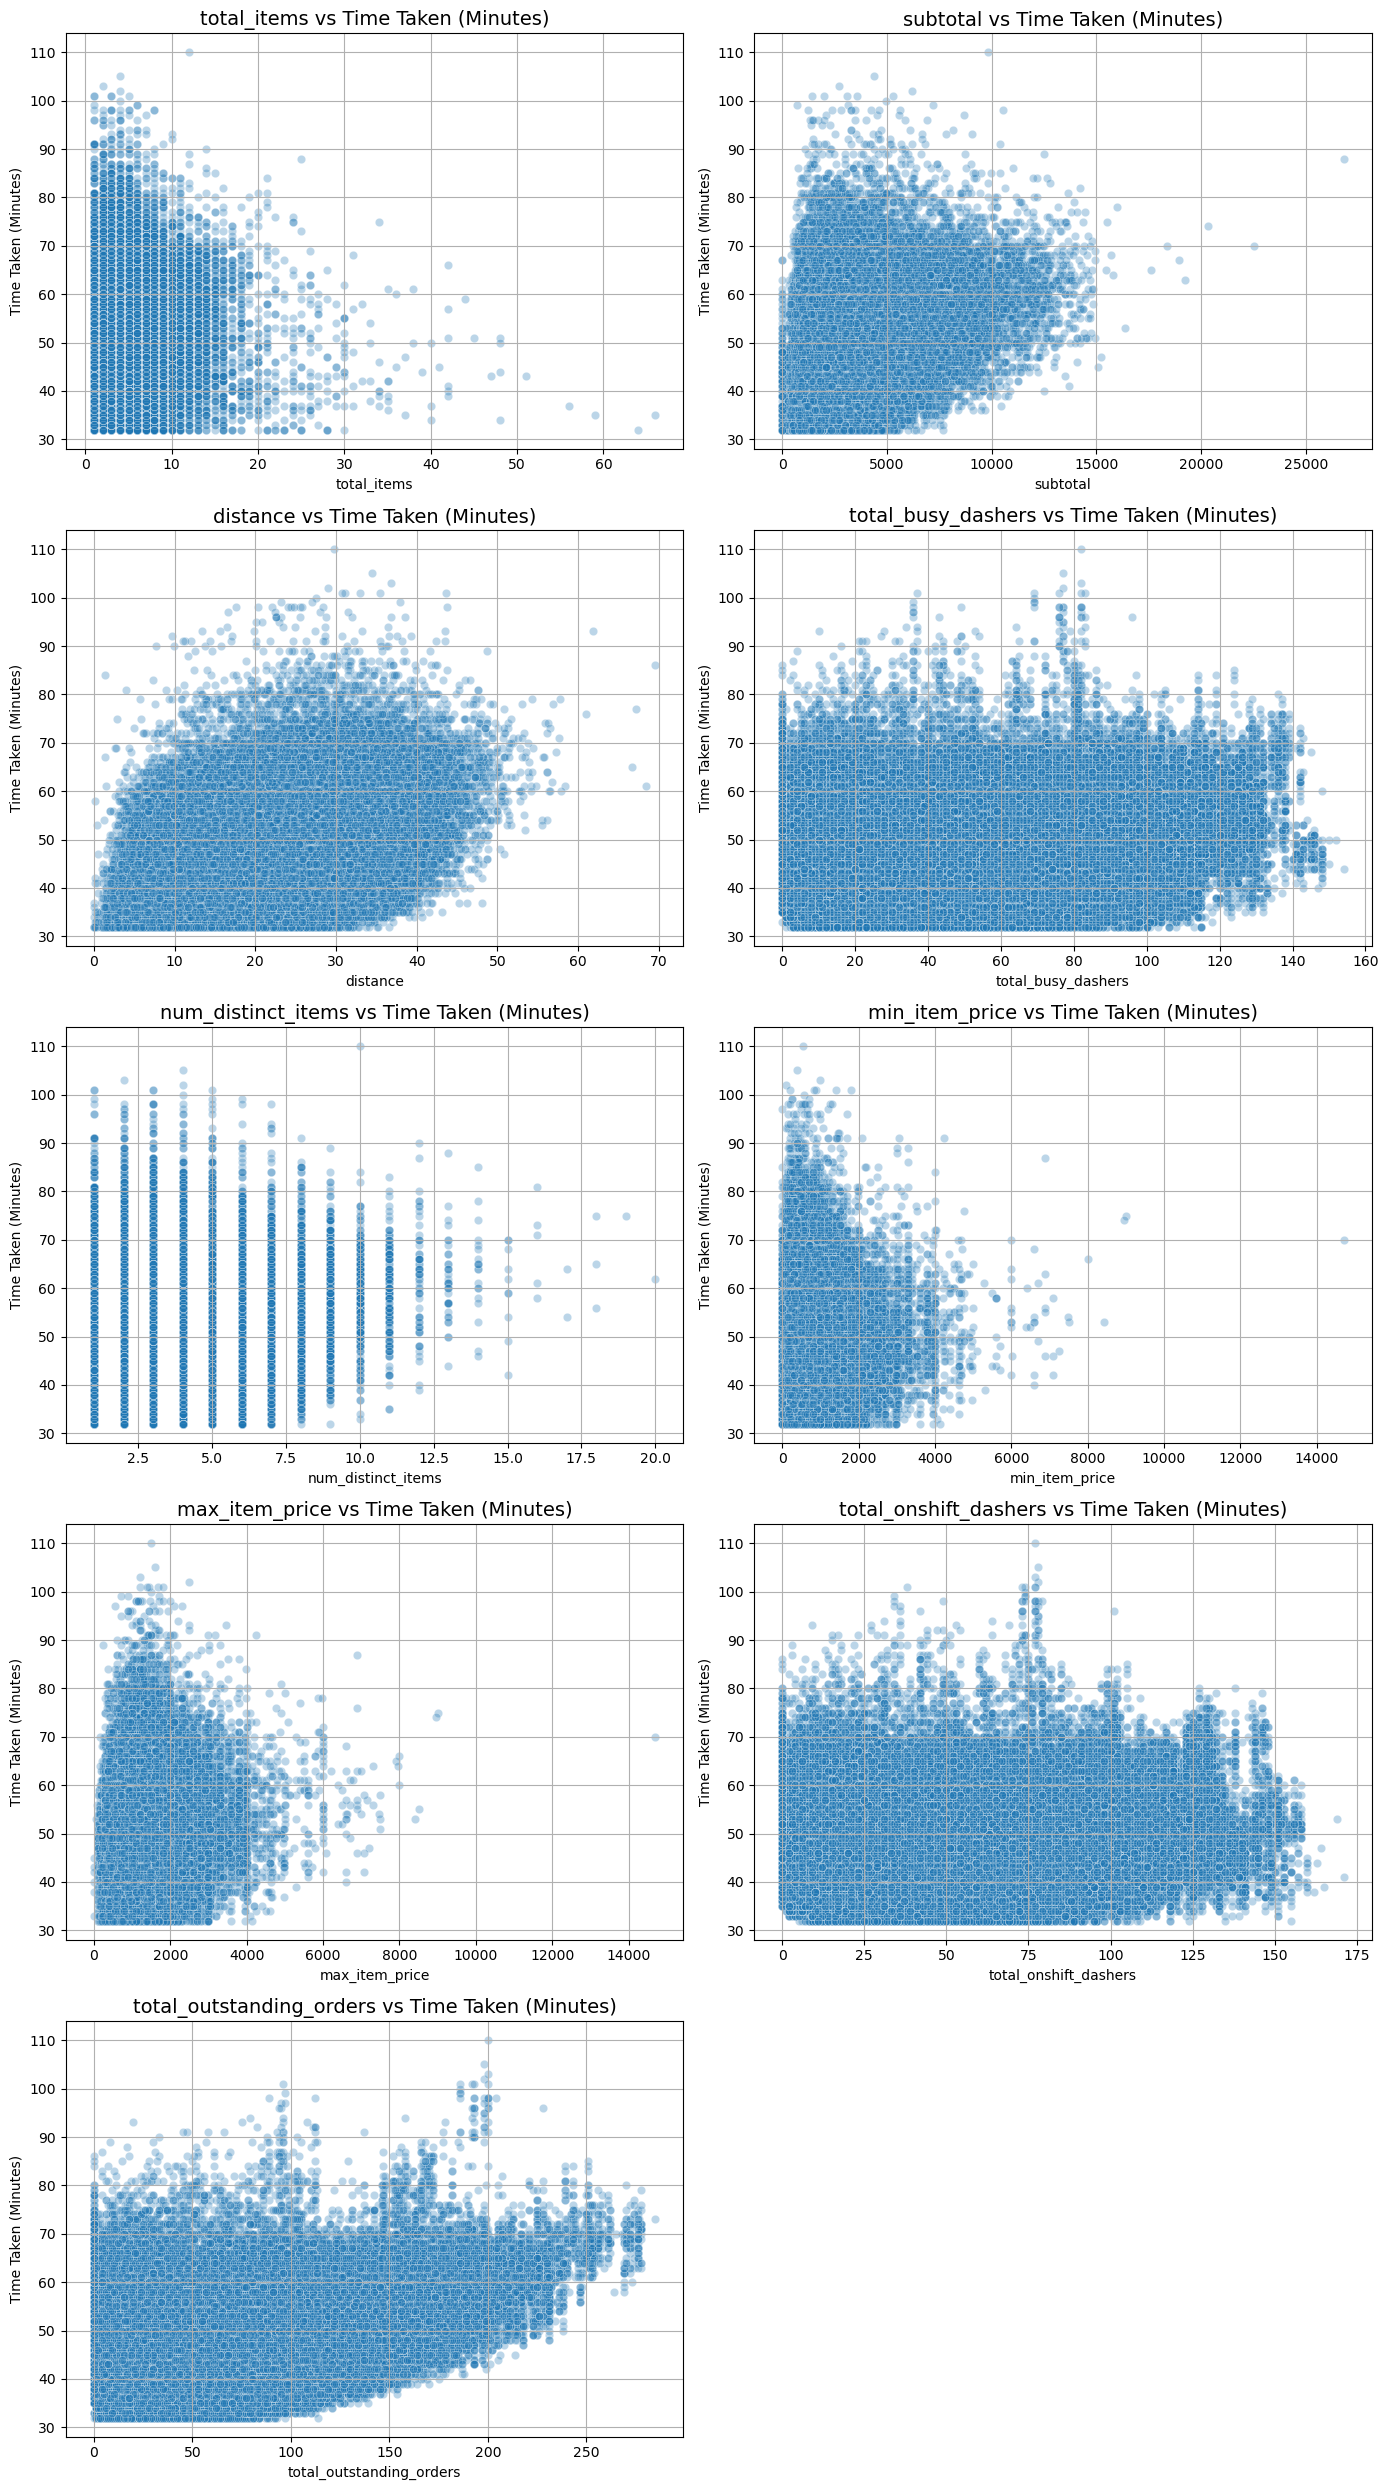

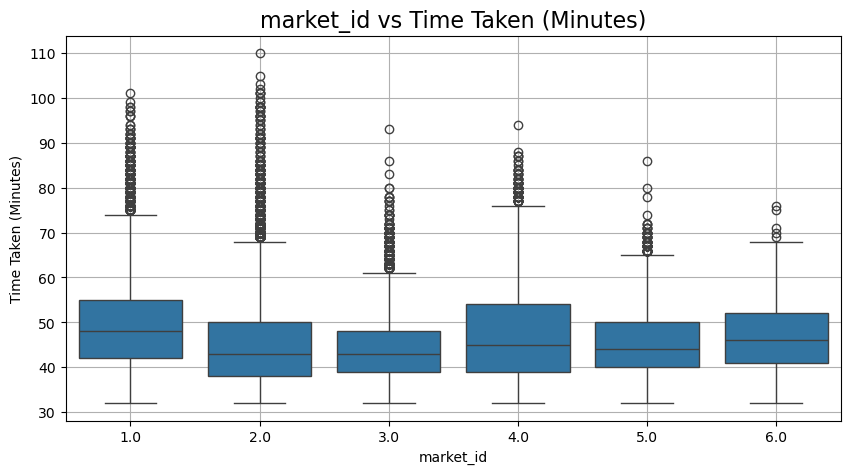

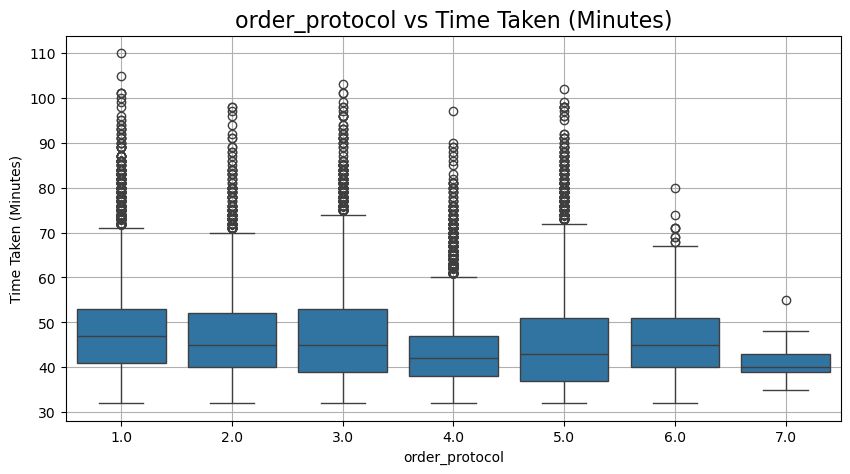

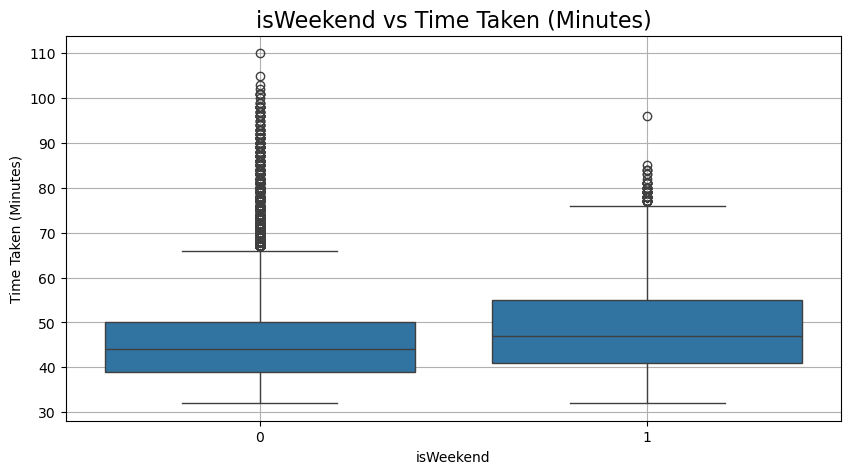

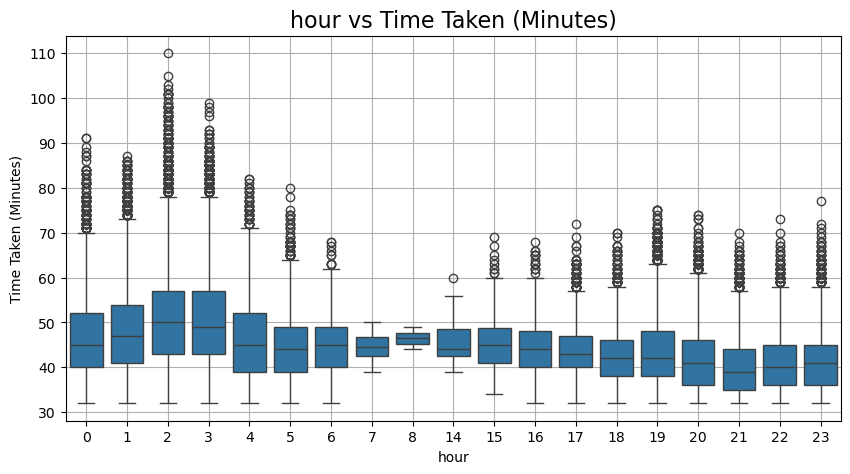

In [481]:
# Scatter plot to visualise the relationship between time_taken and other features
# Bivariant Analysis
important_numerical_features = [
    'total_items', 'subtotal', 'distance', 'total_busy_dashers',
    'num_distinct_items', 'min_item_price', 'max_item_price',
    'total_onshift_dashers', 'total_outstanding_orders'
]

# Assuming important_numerical_features is a list
num_features = len(important_numerical_features)
cols = 2  # Number of columns in the subplot grid
rows = math.ceil(num_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()  # Flatten in case of single row

for i, feature in enumerate(important_numerical_features):
    ax = axes[i]
    sns.scatterplot(x=X_train[feature], y=y_train, alpha=0.3, ax=ax)
    ax.set_title(f'{feature} vs Time Taken (Minutes)', fontsize=14)
    ax.set_xlabel(feature)
    ax.set_ylabel('Time Taken (Minutes)')
    ax.grid(True)

# # Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Box plots are used to visualize the distribution of categorical variables, 
# as scatter plots are not effective in displaying the variance for categorical data.
for feature in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=X_train[feature], y=y_train)
    plt.title(f'{feature} vs Time Taken (Minutes)', fontsize=16)
    plt.xlabel(feature)
    plt.ylabel('Time Taken (Minutes)')
    plt.grid(True)
    plt.show()

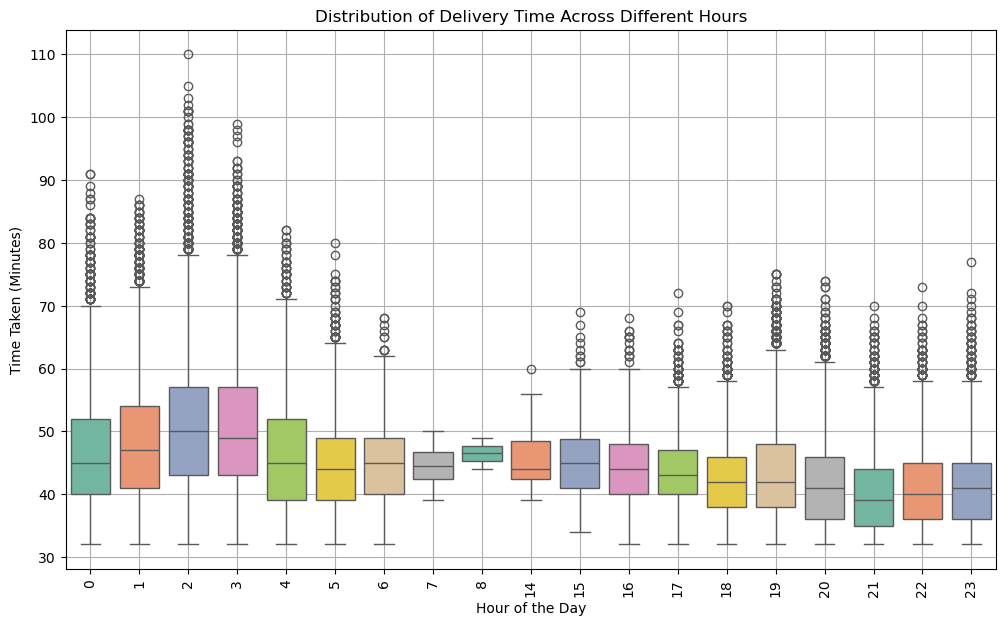

In [482]:
# Show the distribution of time_taken for different hours
plt.figure(figsize=(12, 7))
sns.boxplot(x=X_train['hour'], y=y_train, palette="Set2")

# Customize the plot
plt.title('Distribution of Delivery Time Across Different Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Time Taken (Minutes)')
plt.xticks(rotation=90)  # Rotate the x-axis labels for readability
plt.grid(True)
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

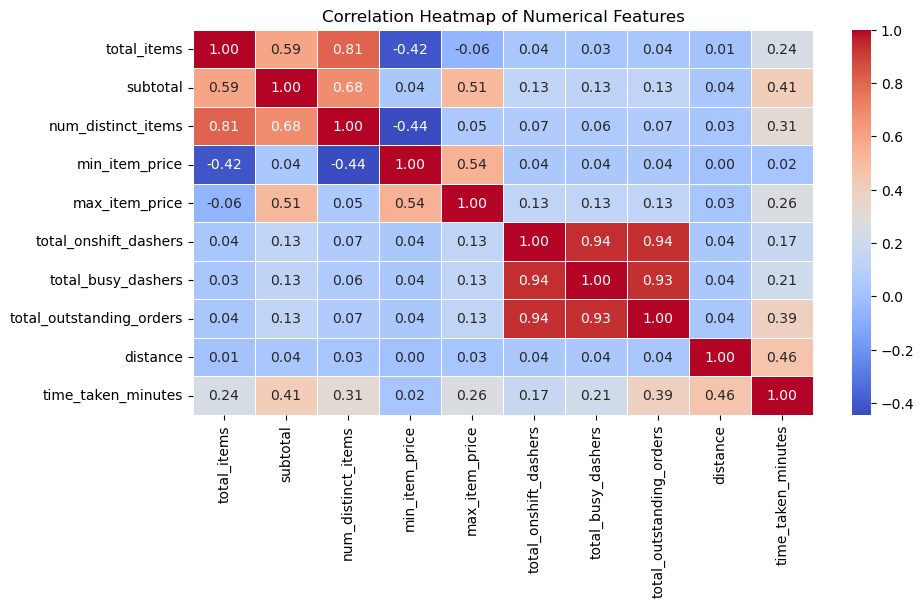

In [487]:
# Plot the heatmap of the correlation matrix
# Create a copy of X_train and add the target column
train_df = X_train.copy()
train_df['time_taken_minutes'] = y_train
new_numerical_cols = numerical_cols + ['time_taken_minutes']

correlations = train_df[new_numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Customize the plot
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [490]:
# Drop 3-5 weakly correlated columns from training dataset

# Step 2: Compute correlations with the target variable
correlations = train_df[new_numerical_cols].corr()['time_taken_minutes'].drop('time_taken_minutes')

# Step 3: Sort by absolute correlation values (weakest first)
weak_correlations = correlations.abs().sort_values()

# Step 4: Select 3–5 weakest features
columns_to_drop = weak_correlations.head(5).index.tolist()
print("Dropping columns with weak correlation:", columns_to_drop)

# Step 5: Drop these columns from X_train
numerical_cols = [col for col in numerical_cols if col not in columns_to_drop]
X_train = X_train.drop(columns=columns_to_drop)
# X_test = X_test.drop(columns=columns_to_drop)

Dropping columns with weak correlation: ['min_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_items', 'max_item_price']


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

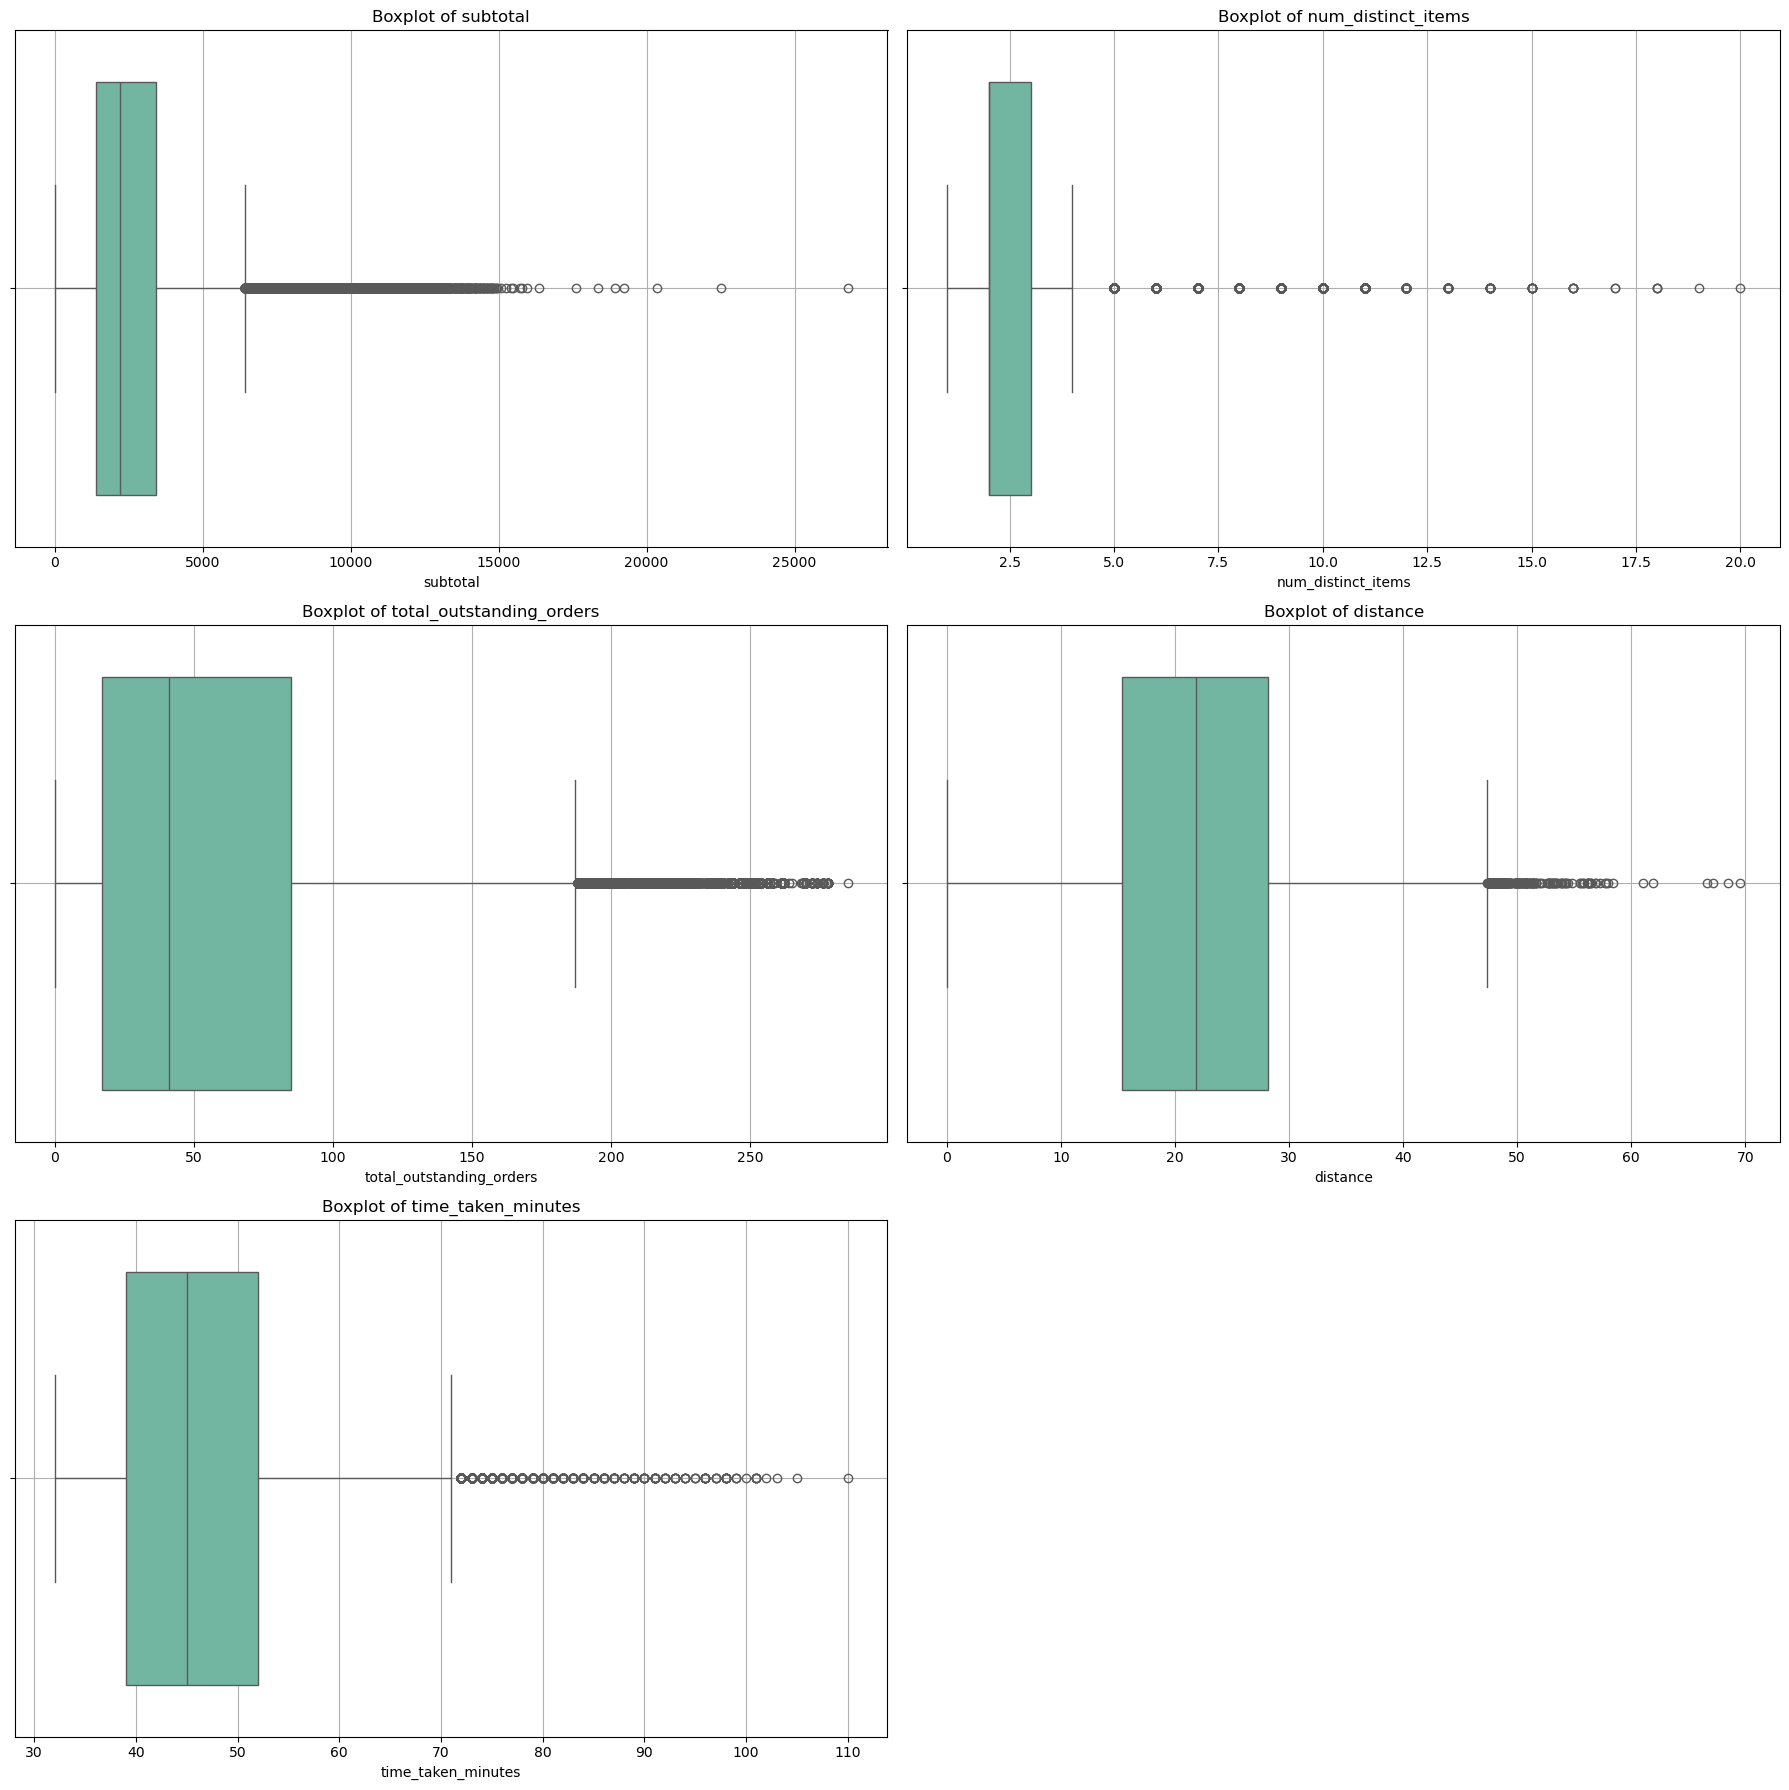

In [494]:
# Boxplot for time_taken
train_df = X_train.copy()
train_df['time_taken_minutes'] = y_train
new_numerical_cols = numerical_cols + ['time_taken_minutes']

# Set up the subplot grid
n_cols = 2  # Number of plots per row
n_rows = (len(new_numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten()  # Flatten in case of a single row

for i, col in enumerate(new_numerical_cols):
    sns.boxplot(x=train_df[col], palette='Set2', ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(col)
    axes[i].grid(True)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [497]:
# Handle outliers
def outlier_percentage(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_limit) | (df[column] > upper_limit)]
    percentage = (len(outliers) / len(df)) * 100
    return round(percentage, 2)

for col in new_numerical_cols:
    percent = outlier_percentage(train_df, col)
    print(f"{col}: {percent}% outliers")

subtotal: 4.56% outliers
num_distinct_items: 11.92% outliers
total_outstanding_orders: 2.96% outliers
distance: 0.18% outliers
time_taken_minutes: 1.02% outliers


Outlier Handling Summary:

subtotal (4.56%) → Cap (IQR): Mild outliers, better to retain data.

num_distinct_items (11.92%) → Cap (IQR): Moderate, avoid losing rows.

total_outstanding_orders (2.96%) → Cap (IQR): Low, safe to cap.

distance (0.18%) → Ignore: Very few outliers, so better to retain data.

hour (0.0%) → Ignore: No outliers.

time_taken_minutes (1.02%) → Ignore: It's usually best to leave the target variable as-is, unless we have evidence that the outliers are incorrect or extremely harmful to the model.

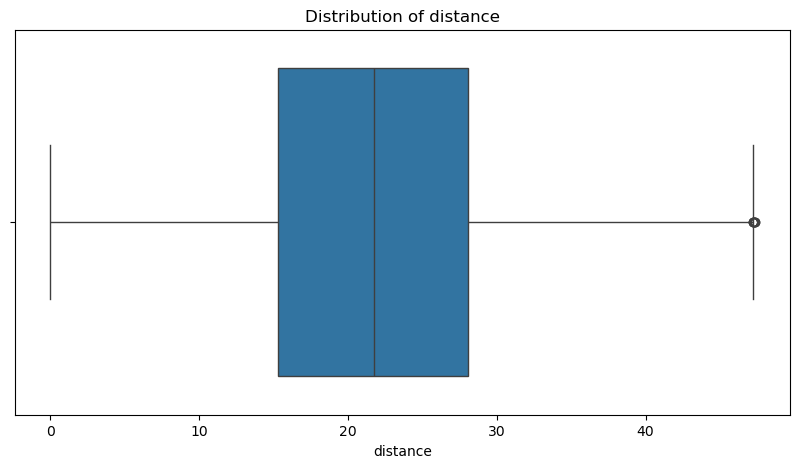

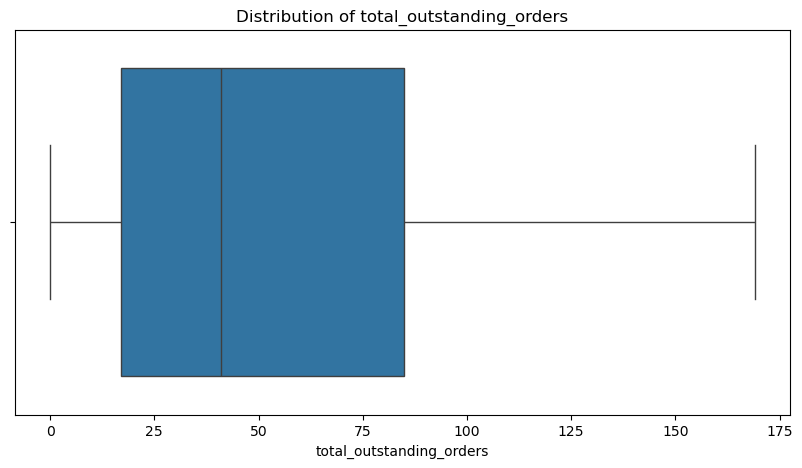

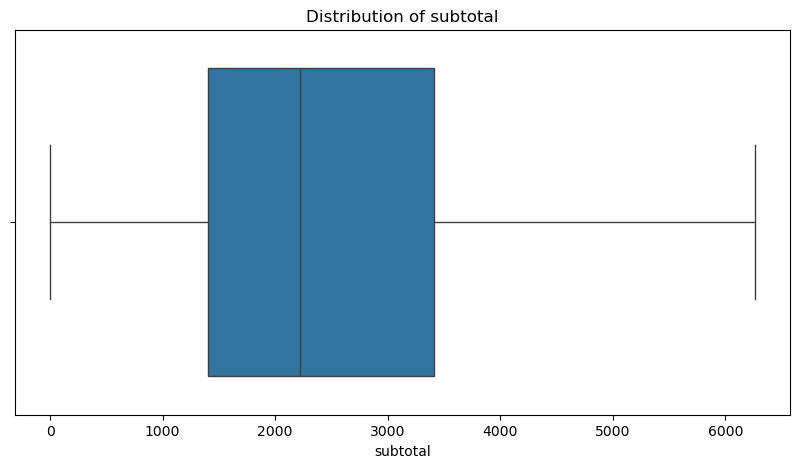

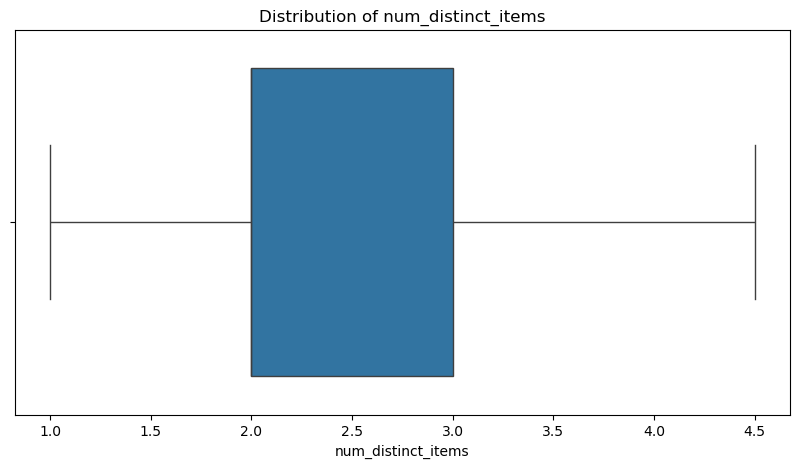

In [500]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]

def cap_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        df[col] = df[col].clip(lower=lower_limit, upper=upper_limit)

    return df

# Handling outliers for distance
# Removing outliers from the 'distance' column, as it contains very few (0.18%) outliers.
col = "distance"
train_df = remove_outliers_iqr(train_df, col)
plt.figure(figsize=(10, 5))
sns.boxplot(x=train_df[col])
plt.title(f'Distribution of {col}')
plt.show()

# Handling outliers for total_outstanding_orders
col = "total_outstanding_orders"
upper_cap = train_df[col].quantile(0.95)
train_df[col] = train_df[col].clip(upper=upper_cap)
plt.figure(figsize=(10, 5))
sns.boxplot(x=train_df[col])
plt.title(f'Distribution of {col}')
plt.show()


# Handling outliers for subtotal
col = "subtotal"
upper_cap = train_df[col].quantile(0.95)
train_df[col] = train_df[col].clip(upper=upper_cap)
plt.figure(figsize=(10, 5))
sns.boxplot(x=train_df[col])
plt.title(f'Distribution of {col}')
plt.show()

# Handling outliers for num_distinct_items
col = "num_distinct_items"
train_df = cap_outliers_iqr(train_df, [col])
plt.figure(figsize=(10, 5))
sns.boxplot(x=train_df[col])
plt.title(f'Distribution of {col}')
plt.show()

# Update X_train and y_train after removing outliers from train_df
X_train = train_df.drop(columns=['time_taken_minutes'])
y_train = train_df['time_taken_minutes']

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

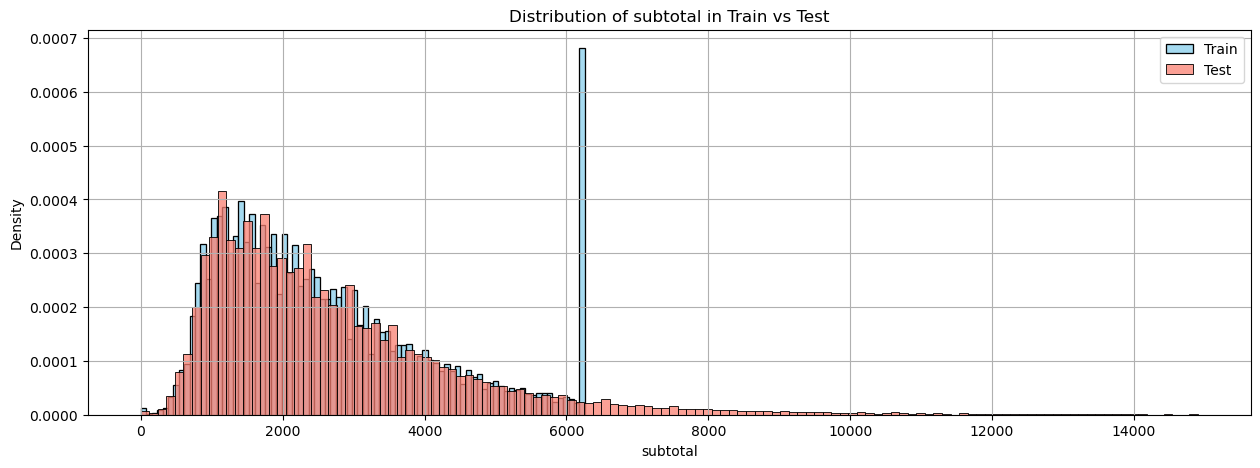

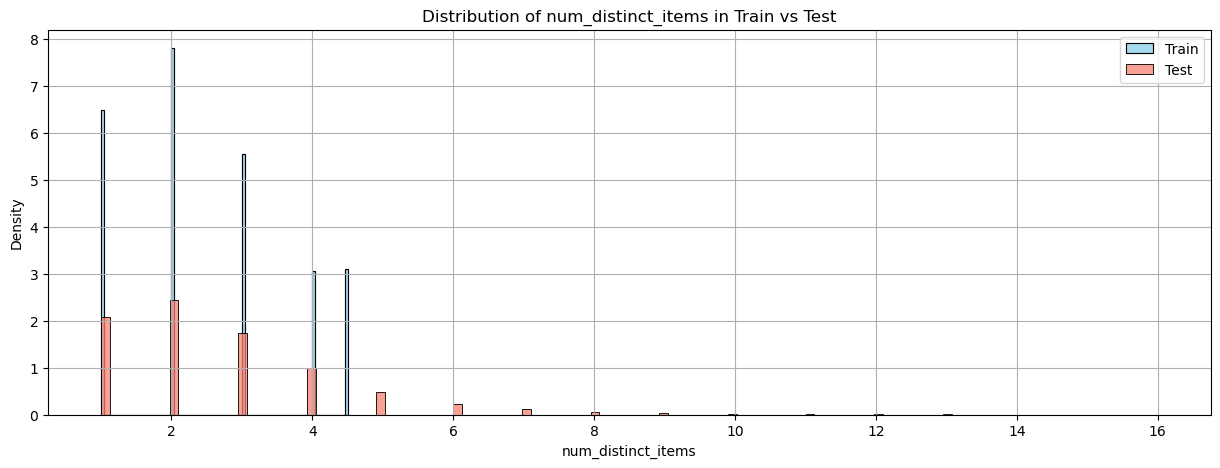

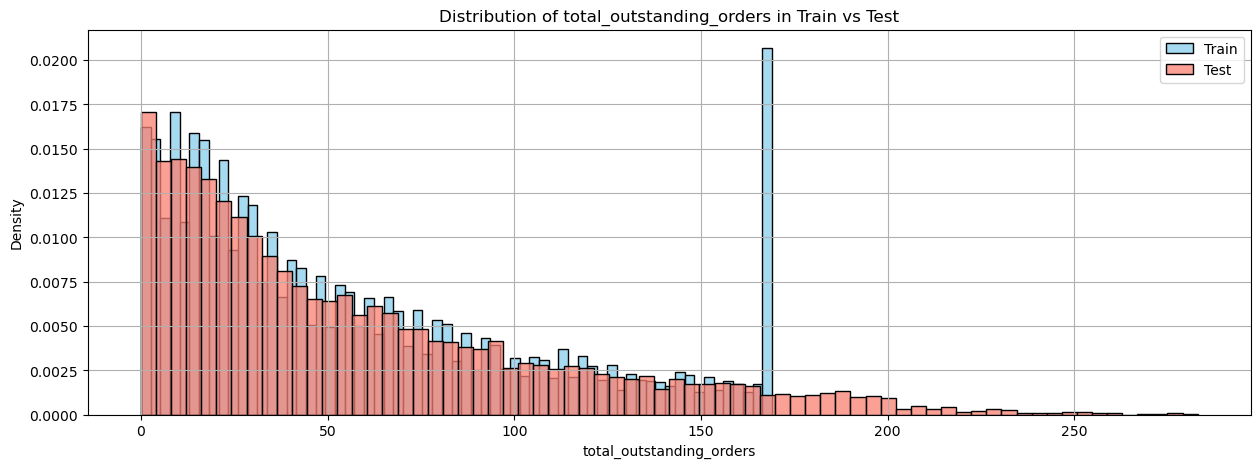

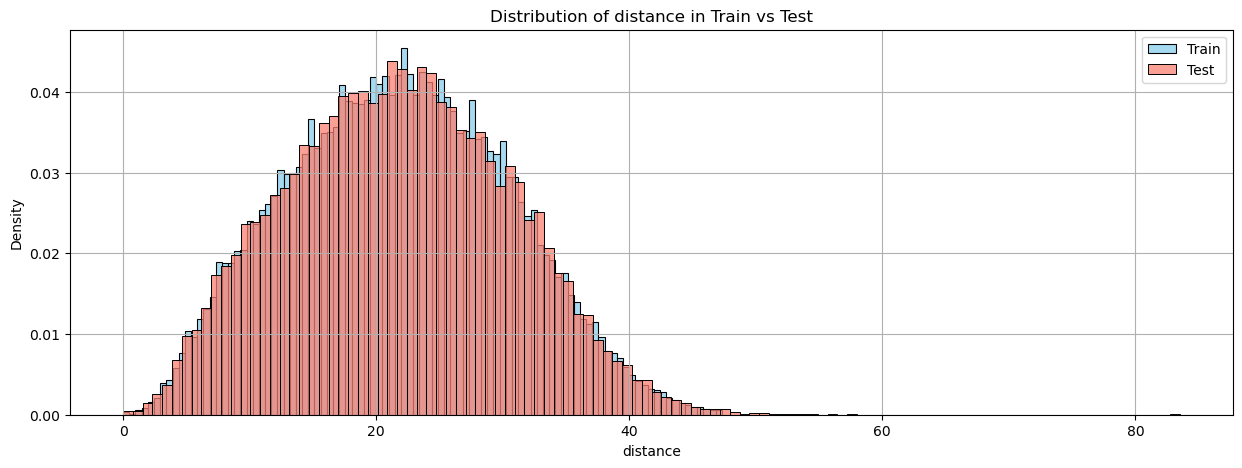

In [503]:
for col in numerical_cols:
    plt.figure(figsize=(15, 5))
    sns.histplot(X_train[col], color='skyblue', label='Train', stat='density')
    sns.histplot(X_test[col], color='salmon', label='Test', stat='density')
    plt.title(f'Distribution of {col} in Train vs Test')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

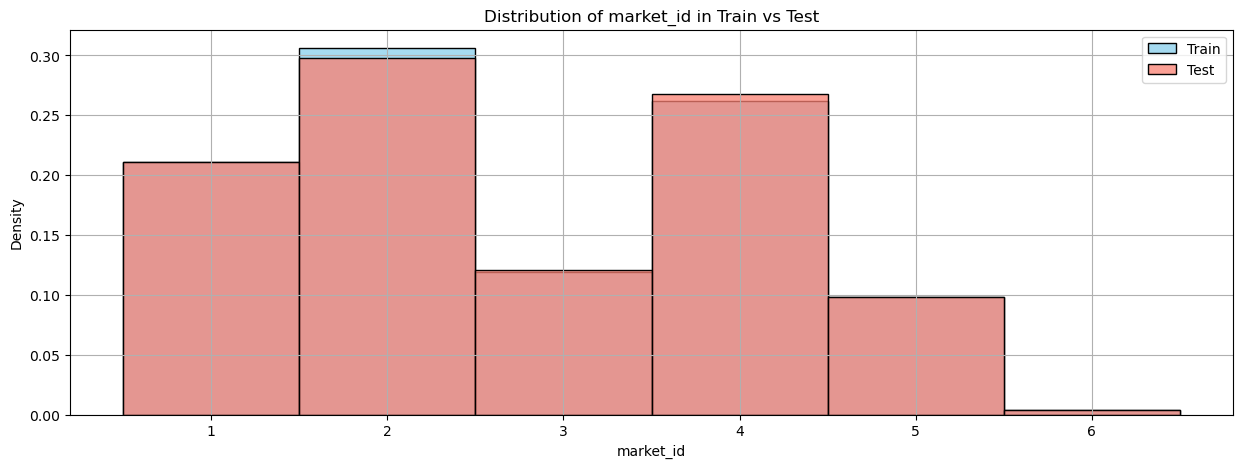

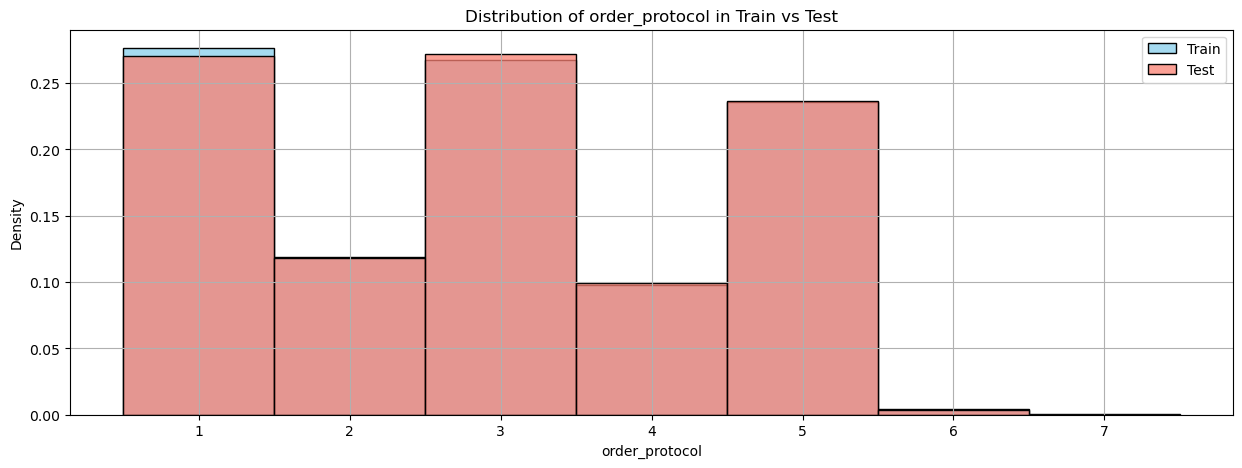

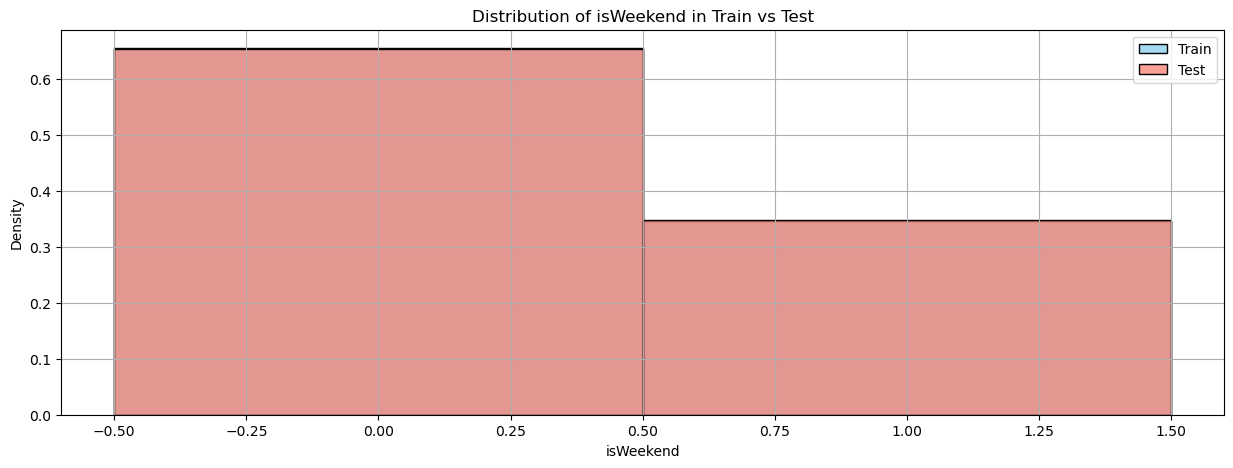

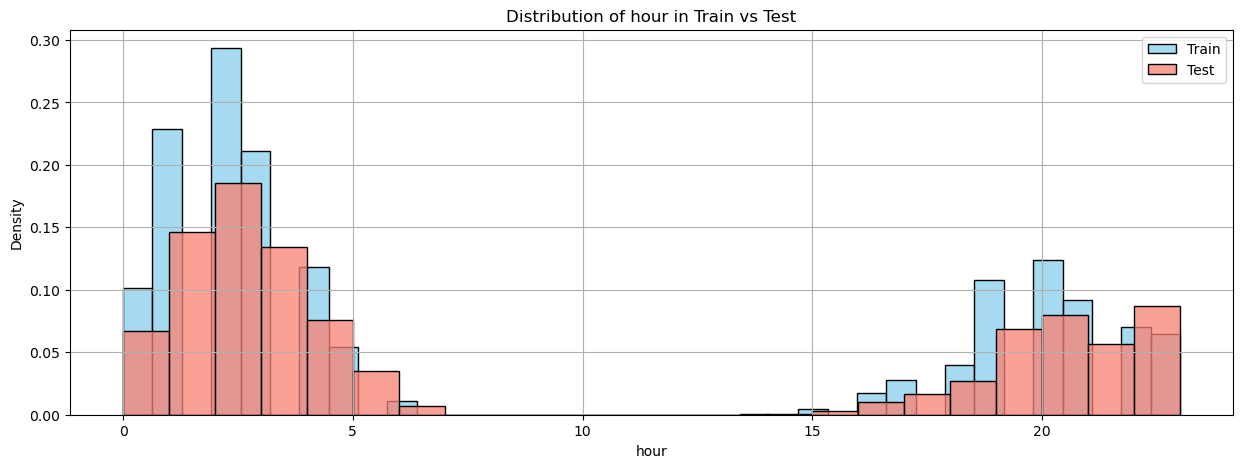

In [505]:
for col in categorical_cols:
    plt.figure(figsize=(15, 5))
    sns.histplot(X_train[col], color='skyblue', label='Train', stat='density')
    sns.histplot(X_test[col], color='salmon', label='Test', stat='density')
    plt.title(f'Distribution of {col} in Train vs Test')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

In [507]:
# Define numerical and categorical columns for easy EDA and data manipulation
# Numerical columns
test_numerical_cols = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'distance'
]

# Categorical columns
test_categorical_cols = [
    'market_id',
    'order_protocol',
    'isWeekend',
    'hour'
]

#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

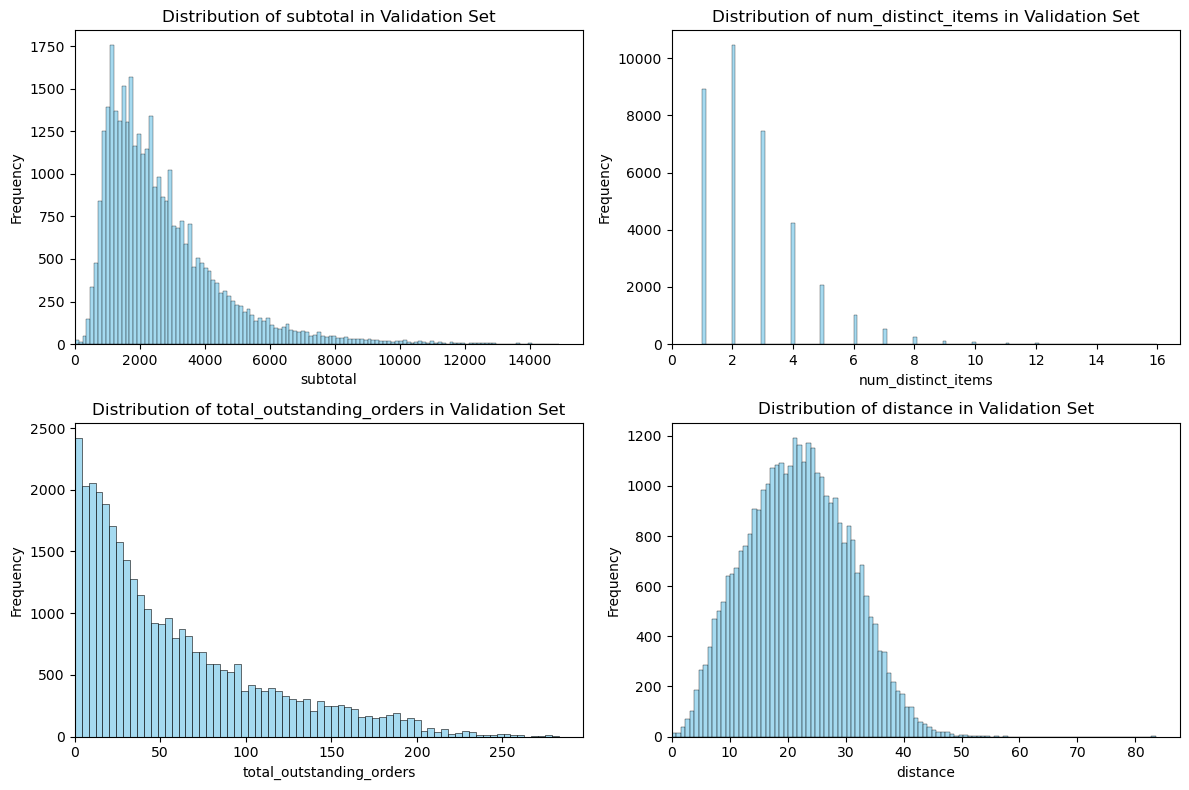

In [511]:
# Plot distributions for all numerical columns
n_cols = 2  # Number of columns per row in subplot grid
n_rows = math.ceil(len(numerical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()  # Flatten to 1D for easy indexing

for i, col in enumerate(numerical_cols):
    sns.histplot(X_test[col], color='skyblue', ax=axes[i])
    axes[i].set_title(f'Distribution of {col} in Validation Set')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(left=0)

# If number of plots < total subplots, remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### **4.1.2**
Check the distribution of categorical features

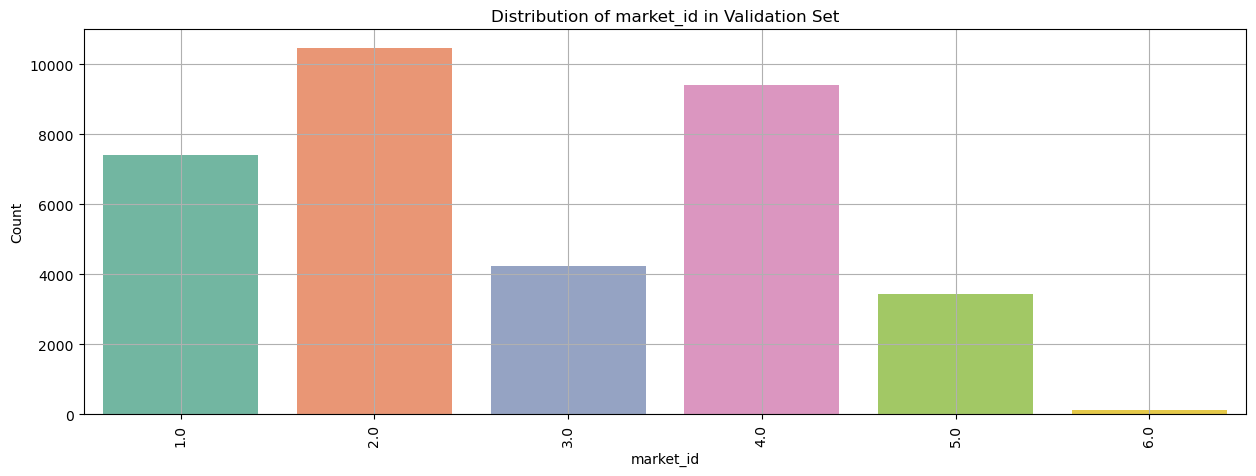

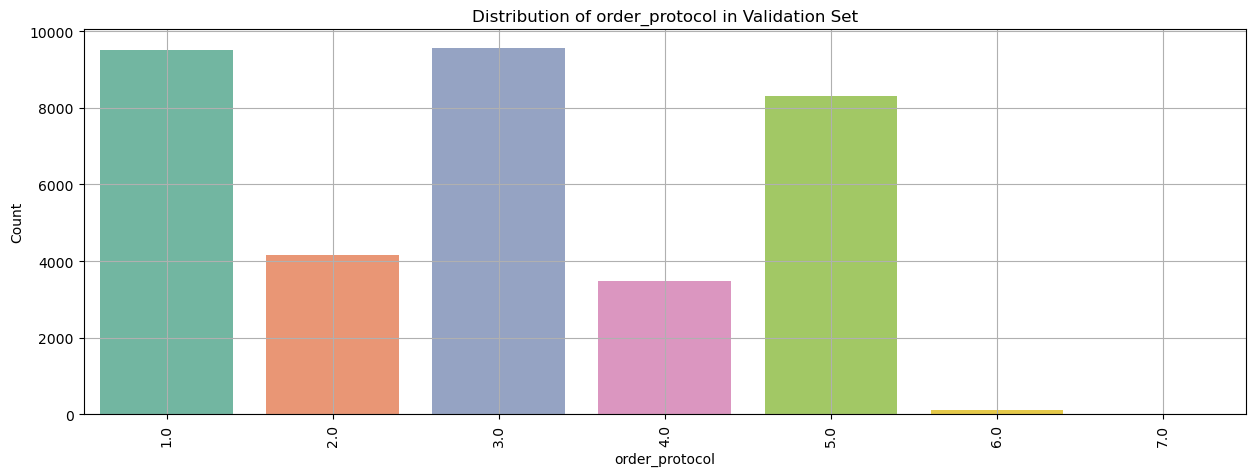

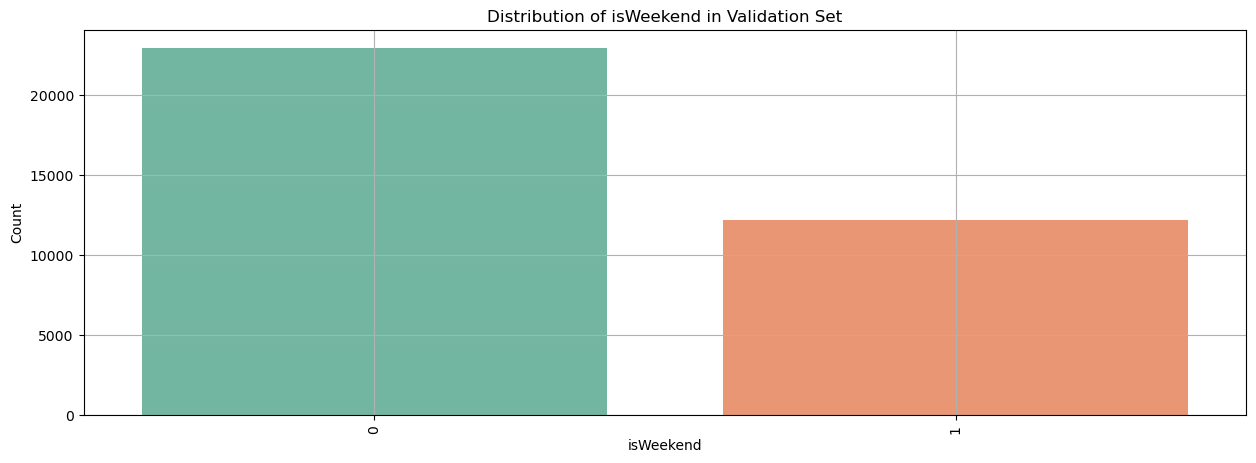

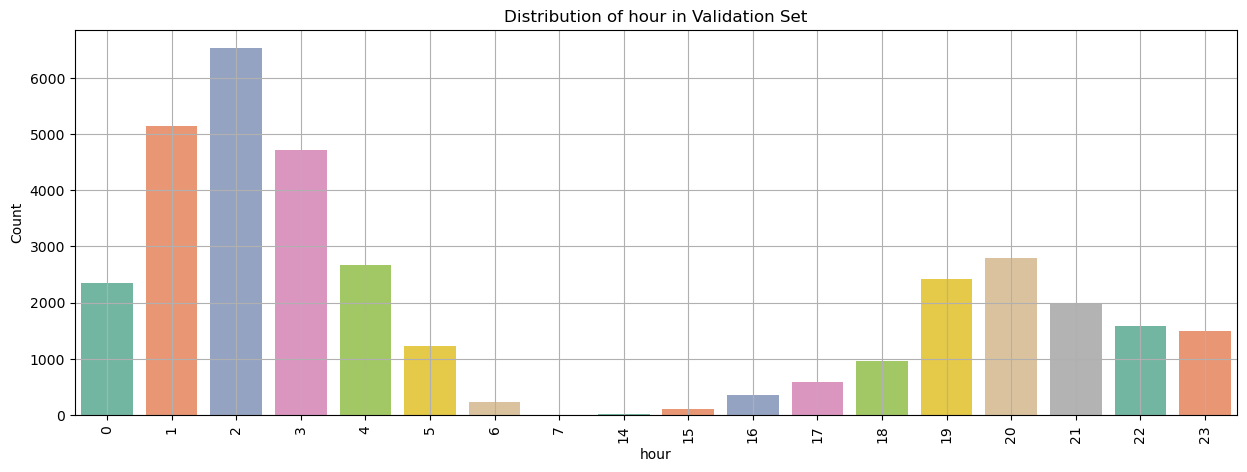

In [514]:
# Distribution of categorical columns
for col in test_categorical_cols:
    plt.figure(figsize=(15, 5))
    sns.countplot(x=X_test[col], palette='Set2')  # countplot to show counts of categories
    plt.title(f'Distribution of {col} in Validation Set')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=90)  # Rotate x labels for better visibility if needed
    plt.grid(True)
    plt.show()

##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

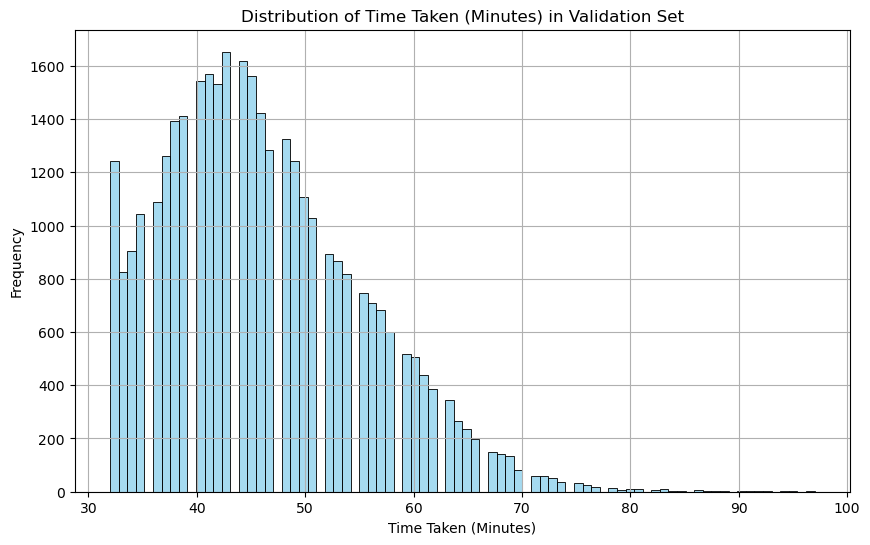

In [517]:
# Distribution of time_taken
plt.figure(figsize=(10, 6))
sns.histplot(y_test, color='skyblue') 
plt.title('Distribution of Time Taken (Minutes) in Validation Set')
plt.xlabel('Time Taken (Minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

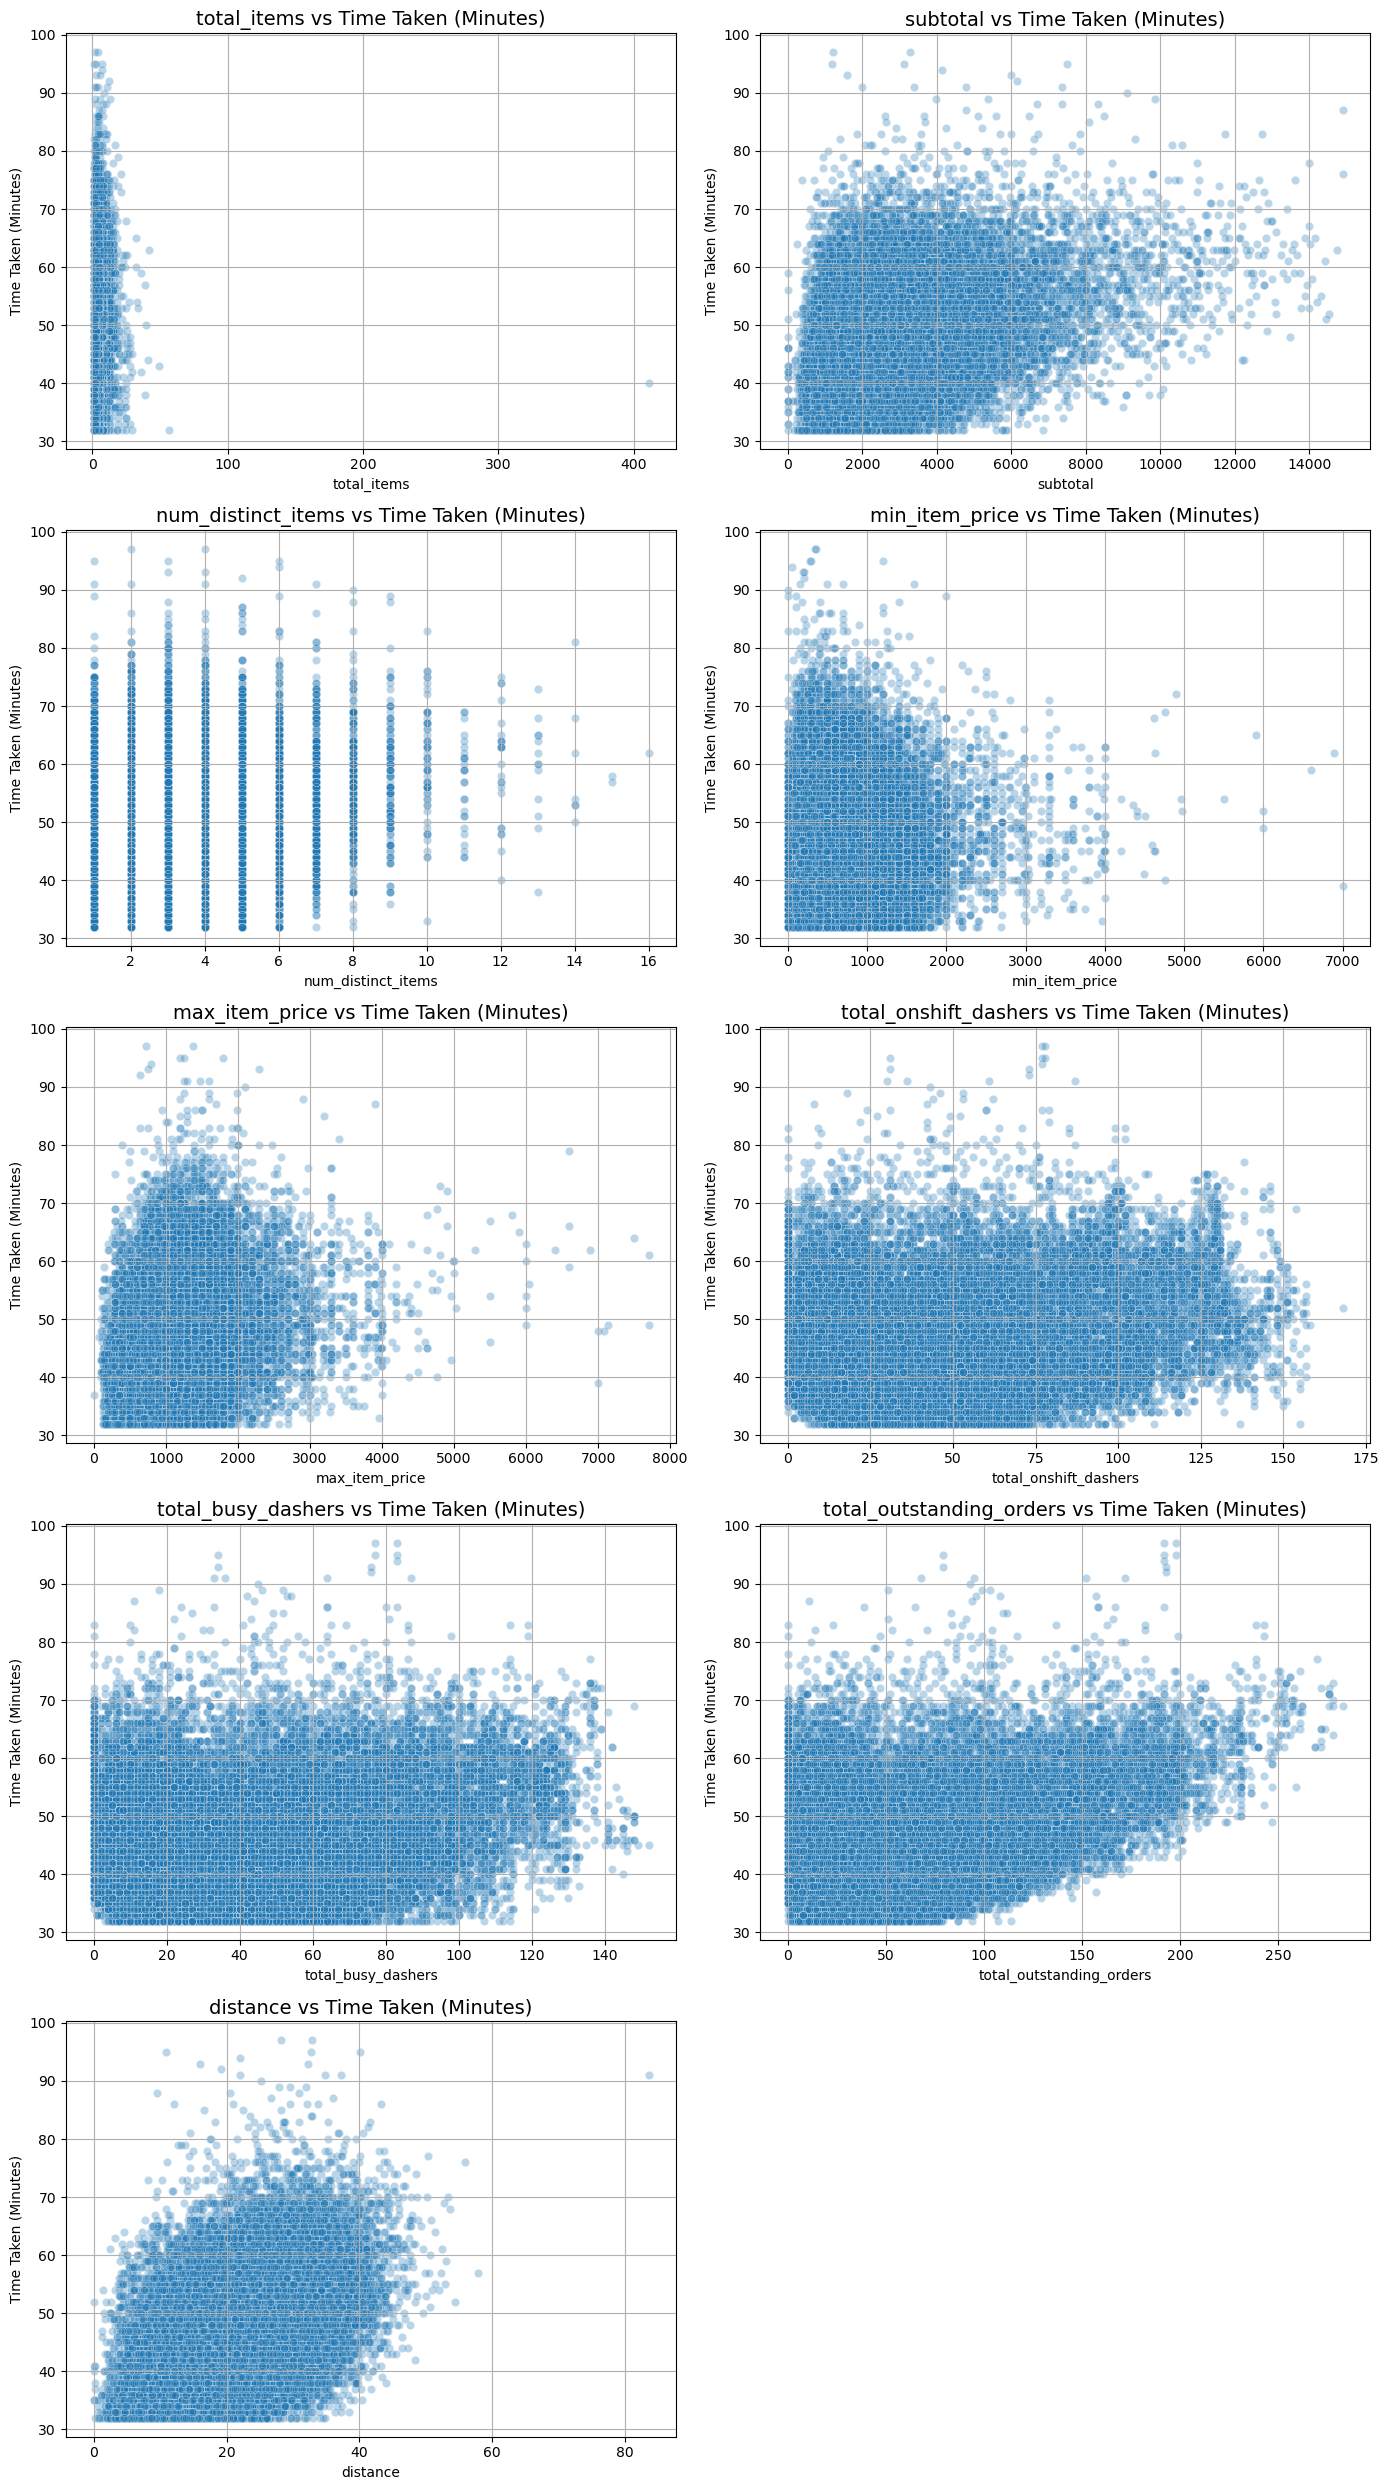

In [520]:
# Scatter plot to visualise the relationship between time_taken and other features

# Assuming important_numerical_features is a list
num_features = len(test_numerical_cols)
cols = 2 
rows = math.ceil(num_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()  # Flatten in case of single row

for i, feature in enumerate(test_numerical_cols):
    ax = axes[i]
    sns.scatterplot(x=X_test[feature], y=y_test, alpha=0.3, ax=ax)
    ax.set_title(f'{feature} vs Time Taken (Minutes)', fontsize=14)
    ax.set_xlabel(feature)
    ax.set_ylabel('Time Taken (Minutes)')
    ax.grid(True)

# # Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### **4.3** Drop the columns with weak correlations with the target variable

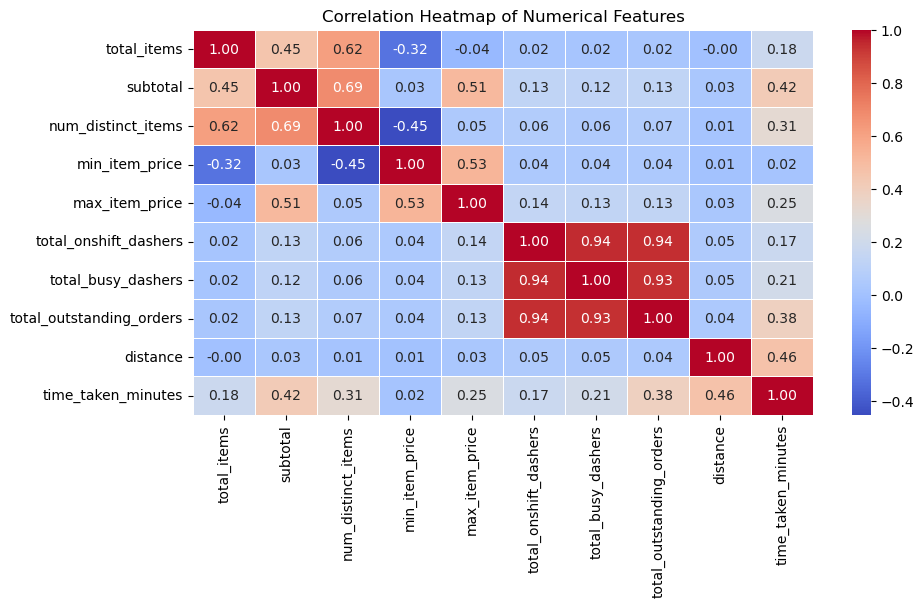

Dropping columns with weak correlation: ['min_item_price', 'total_onshift_dashers', 'total_items', 'total_busy_dashers', 'max_item_price']


In [523]:
# Drop the weakly correlated columns from training dataset

# Create a copy of X_train and add the target column
test_df = X_test.copy()
test_df['time_taken_minutes'] = y_test
test_new_numerical_cols = test_numerical_cols + ['time_taken_minutes']

correlations = test_df[test_new_numerical_cols].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 5))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Compute correlations with the target variable
correlations = test_df[test_new_numerical_cols].corr()['time_taken_minutes'].drop('time_taken_minutes')

# Sort by absolute correlation values (weakest first)
weak_correlations = correlations.abs().sort_values()
# Step 4: Select 3–5 weakest features
columns_to_drop = weak_correlations.head(5).index.tolist()
print("Dropping columns with weak correlation:", columns_to_drop)

# Drop these columns from X_test
numerical_cols = [col for col in test_numerical_cols if col not in columns_to_drop]
X_test = X_test.drop(columns=columns_to_drop)

## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [527]:
# Import libraries
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [530]:
# Apply scaling to the numerical columns

# Concatenate X_train and X_test
X_combined = pd.concat([X_train, X_test], axis=0)

# Create dummies
X_combined = pd.get_dummies(X_combined, columns=['market_id', 'order_protocol', 'hour'], drop_first=True, dtype=int)

# Now split back
X_train = X_combined.iloc[:len(X_train)]
X_test = X_combined.iloc[len(X_train):]

# Scaling
scaler = StandardScaler()
X_train_scalar = scaler.fit_transform(X_train)
X_test_scalar = scaler.transform(X_test)

X_train_df=pd.DataFrame(X_train_scalar,columns=X_train.columns)
X_test_df=pd.DataFrame(X_test_scalar,columns=X_test.columns)

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [535]:
# Create/Initialise the model

# Add a constant term (intercept) manually
X_train_sm = sm.add_constant(X_train)

# Initialize the OLS model
model = sm.OLS(y_train, X_train_sm)

In [537]:
# Train the model using the training data
# Fit the model
results = model.fit()

# Check the model summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     time_taken_minutes   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     6623.
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        20:32:04   Log-Likelihood:            -4.4528e+05
No. Observations:              140291   AIC:                         8.906e+05
Df Residuals:                  140256   BIC:                         8.910e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [539]:
# Make predictions

# Add constant (intercept) term to X_test
X_test_sm = sm.add_constant(X_test)

# Make predictions using the trained model
y_pred = results.predict(X_test_sm)

# Step 5: Output the predictions
print(y_pred.head())  # Displaying the first few predictions

110142    38.773771
79473     46.921177
122833    45.375082
69608     52.219843
100630    39.309245
dtype: float64


Mean Absolute Error (MAE): 4.271580762294824
Mean Squared Error (MSE): 30.986655853982555
Root Mean Squared Error (RMSE): 5.566565894156159
R-squared: 0.6162117324238633


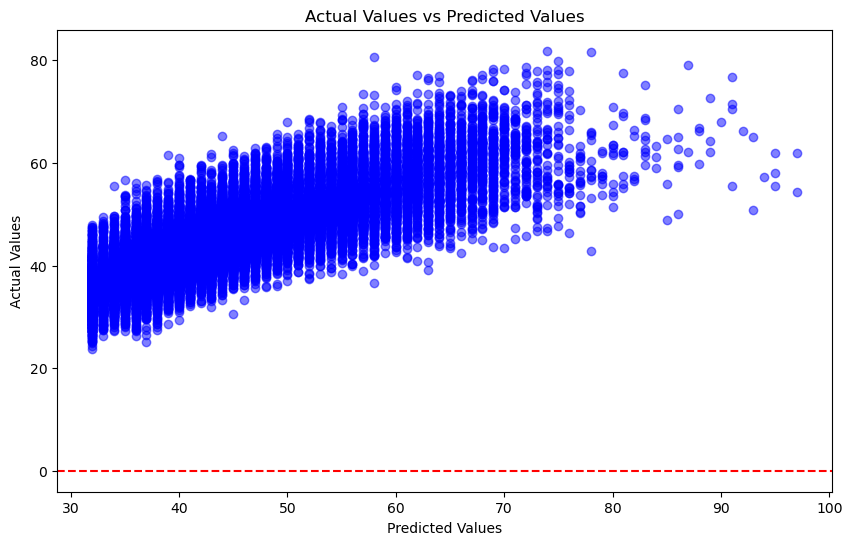

In [541]:
# Find results for evaluation metrics

# Calculate residuals (actual - predicted)
residuals = y_test - y_pred

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)

# Calculate MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# R-squared (already available from the model summary, but you can calculate manually as well)
r_squared = results.rsquared  # or manually: 1 - (sum of squared residuals / total sum of squares)

# Output the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r_squared}")

# Scatter plot for y_pred vs y_test
plt.figure(figsize=(10, 6))
plt.scatter(y=y_pred, x=y_test, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Actual Values vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

    Num_Features      RMSE  R2_Score
0              1  8.913127  0.057577
1              2  8.715579  0.098889
2              3  8.715759  0.098852
3              4  8.661427  0.110052
4              5  8.622409  0.118052
5              6  8.588973  0.124879
6              7  8.527184  0.137425
7              8  8.512004  0.140493
8              9  8.485524  0.145832
9             10  8.475107  0.147928
10            11  8.380546  0.166836
11            12  8.347447  0.173404
12            13  8.318381  0.179151
13            14  8.241229  0.194307
14            15  8.215292  0.199370
15            16  8.174605  0.207281
16            17  8.171651  0.207854
17            18  8.169155  0.208337
18            19  8.169150  0.208338
19            20  8.157331  0.210627
20            21  8.100664  0.221557
21            22  8.100068  0.221671
22            23  7.778015  0.282332
23            24  7.777929  0.282348
24            25  7.770990  0.283628
25            26  7.761607  0.285357
2

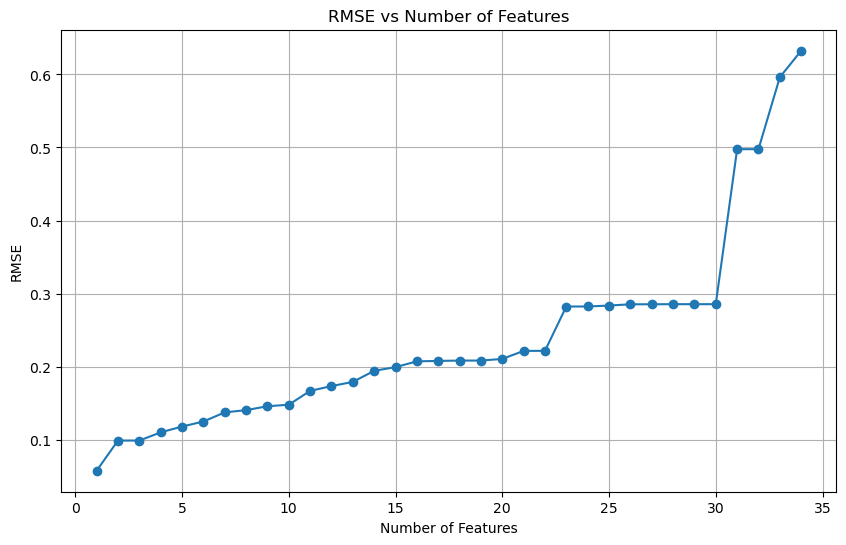

In [546]:
# Loop through the number of features and test the model

# Initialize the model
base_model = LinearRegression()

n_features = X_train.shape[1]  # Should be 41 based on your column list
rfe_results = []

# 3. Loop over number of features
for i in range(1, n_features + 1):
    rfe = RFE(estimator=base_model, n_features_to_select=i)
    rfe.fit(X_train, y_train)

    # Transform X_train and X_test
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    # Train the model
    model = LinearRegression()
    model.fit(X_train_rfe, y_train)

    # Predict
    y_pred = model.predict(X_test_rfe)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Save results
    rfe_results.append({
        'Num_Features': i,
        'RMSE': rmse,
        'R2_Score': r2
    })

# 4. Create DataFrame
rfe_results_df = pd.DataFrame(rfe_results)

# 5. Show results
print(rfe_results_df)

# 6. Plot RMSE vs Number of Features
plt.figure(figsize=(10,6))
plt.plot(rfe_results_df['Num_Features'], rfe_results_df['R2_Score'], marker='o')
plt.title('RMSE vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

In [547]:
# Select the 31 best features using RFE
rfe_final = RFE(estimator=LinearRegression(), n_features_to_select=31)
rfe_final.fit(X_train, y_train)

# Selected features
selected_features = X_train.columns[rfe_final.get_support()]
print("Selected Features:", selected_features)

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Step 2: Train the final Linear Regression model on selected features
final_model = LinearRegression()
final_model.fit(X_train_selected, y_train)
y_pred_final = final_model.predict(X_test_selected)

# Step 3: Evaluate the model
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_r2 = r2_score(y_test, y_pred_final)
print(f"\nFinal RMSE: {final_rmse}")
print(f"Final R² Score: {final_r2}")

# Step 4: OLS Summary and VIF
X_test_sm = sm.add_constant(X_test_selected)
X_train_sm = sm.add_constant(X_train_selected)
model_ols = sm.OLS(y_train, X_train_sm).fit()
print(model_ols.summary())

# VIF Calculation
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_sm.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
print("\nVIF Table:\n", vif_data)

Selected Features: Index(['num_distinct_items', 'distance', 'isWeekend', 'market_id_2.0',
       'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0',
       'order_protocol_2.0', 'order_protocol_3.0', 'order_protocol_4.0',
       'order_protocol_5.0', 'order_protocol_6.0', 'order_protocol_7.0',
       'hour_1', 'hour_2', 'hour_3', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

Final RMSE: 6.507534213700949
Final R² Score: 0.4976357506359249
                            OLS Regression Results                            
Dep. Variable:     time_taken_minutes   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     4263.
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time

Based on the VIF summary, the VIF values for all features range between 1.000 and 1.9, which falls within the acceptable threshold, indicating low multicollinearity.

According to the model summary, the variable hour_8 has the highest p-value, suggesting it is not statistically significant. Therefore, we are dropping this feature to potentially improve the model's performance.

In [549]:
X_train_sm=X_train_sm.drop("hour_8",axis=1)
X_test_sm=X_test_sm.drop("hour_8",axis=1)

model2=sm.OLS(np.array(y_train),X_train_sm)# Ordinary Least Squares
res2=model2.fit()
print(res2.summary())

vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_sm.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_sm.values,i) 
                 for i in range(len(X_train_sm.columns))]
vif_data

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     4406.
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        20:32:33   Log-Likelihood:            -4.6589e+05
No. Observations:              140291   AIC:                         9.318e+05
Df Residuals:                  140260   BIC:                         9.321e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 35.0541      0

Feature        VIF
0                const  23.388294
1   num_distinct_items   1.033298
2             distance   1.010623
3            isWeekend   1.015974
4        market_id_2.0   1.777686
5        market_id_3.0   1.387801
6        market_id_4.0   1.755985
7        market_id_5.0   1.341691
8        market_id_6.0   1.014283
9   order_protocol_2.0   1.313753
10  order_protocol_3.0   1.566027
11  order_protocol_4.0   1.235019
12  order_protocol_5.0   1.506339
13  order_protocol_6.0   1.014410
14  order_protocol_7.0   1.001399
15              hour_1   1.753481
16              hour_2   1.906619
17              hour_3   1.700646
18              hour_5   1.206103
19              hour_6   1.049611
20              hour_7   1.000466
21             hour_14   1.002093
22             hour_15   1.021002
23             hour_16   1.070614
24             hour_17   1.108794
25             hour_18   1.152594
26             hour_19   1.392185
27             hour_20   1.444431
28             hour_21   1.339092
29             hour_22   1.263781
30             hour_23   1.245424

Based on the model summary, order_protocol_7 has the highest p-value, indicating it is not statistically significant. Therefore, we are dropping this column to potentially improve model performance.

In [551]:
X_train_sm=X_train_sm.drop("order_protocol_7.0",axis=1)
X_test_sm=X_test_sm.drop("order_protocol_7.0",axis=1)

model3=sm.OLS(np.array(y_train),X_train_sm)# Ordinary Least Squares
res3=model3.fit()
print(res3.summary())

vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_sm.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_sm.values,i) 
                 for i in range(len(X_train_sm.columns))]
vif_data

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     4557.
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        20:32:38   Log-Likelihood:            -4.6589e+05
No. Observations:              140291   AIC:                         9.318e+05
Df Residuals:                  140261   BIC:                         9.321e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 35.0538      0

Feature        VIF
0                const  23.386220
1   num_distinct_items   1.033291
2             distance   1.010534
3            isWeekend   1.015959
4        market_id_2.0   1.777665
5        market_id_3.0   1.387801
6        market_id_4.0   1.755970
7        market_id_5.0   1.340681
8        market_id_6.0   1.014283
9   order_protocol_2.0   1.313602
10  order_protocol_3.0   1.565824
11  order_protocol_4.0   1.234846
12  order_protocol_5.0   1.506153
13  order_protocol_6.0   1.014405
14              hour_1   1.753476
15              hour_2   1.906611
16              hour_3   1.700606
17              hour_5   1.206101
18              hour_6   1.049611
19              hour_7   1.000466
20             hour_14   1.002093
21             hour_15   1.021001
22             hour_16   1.070614
23             hour_17   1.108794
24             hour_18   1.152593
25             hour_19   1.392183
26             hour_20   1.444430
27             hour_21   1.339075
28             hour_22   1.263780
29             hour_23   1.245392

Based on the model summary, hour_7 has the highest p-value, indicating it is not statistically significant. Therefore, we are dropping this column to potentially improve model performance.

In [553]:
X_train_sm=X_train_sm.drop("hour_7",axis=1)
X_test_sm=X_test_sm.drop("hour_7",axis=1)

model4=sm.OLS(np.array(y_train),X_train_sm)# Ordinary Least Squares
res4=model4.fit()
print(res4.summary())

vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_sm.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_sm.values,i) 
                 for i in range(len(X_train_sm.columns))]
vif_data

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     4720.
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        20:32:41   Log-Likelihood:            -4.6589e+05
No. Observations:              140291   AIC:                         9.318e+05
Df Residuals:                  140262   BIC:                         9.321e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 35.0532      0

Feature        VIF
0                const  23.383143
1   num_distinct_items   1.033289
2             distance   1.010533
3            isWeekend   1.015916
4        market_id_2.0   1.777639
5        market_id_3.0   1.387798
6        market_id_4.0   1.755968
7        market_id_5.0   1.340666
8        market_id_6.0   1.014283
9   order_protocol_2.0   1.313579
10  order_protocol_3.0   1.565799
11  order_protocol_4.0   1.234844
12  order_protocol_5.0   1.506130
13  order_protocol_6.0   1.014404
14              hour_1   1.753126
15              hour_2   1.906180
16              hour_3   1.700268
17              hour_5   1.205996
18              hour_6   1.049583
19             hour_14   1.002092
20             hour_15   1.020993
21             hour_16   1.070578
22             hour_17   1.108739
23             hour_18   1.152519
24             hour_19   1.392008
25             hour_20   1.444227
26             hour_21   1.338913
27             hour_22   1.263649
28             hour_23   1.245271

Based on the model summary, hour_14 has the highest p-value, indicating it is not statistically significant. Therefore, we are dropping this column to potentially improve model performance.

In [560]:
X_train_sm=X_train_sm.drop("hour_14",axis=1)
X_test_sm=X_test_sm.drop("hour_14",axis=1)

model5=sm.OLS(np.array(y_train),X_train_sm)# Ordinary Least Squares
res5=model5.fit()
print(res5.summary())

vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_sm.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_sm.values,i) 
                 for i in range(len(X_train_sm.columns))]
vif_data

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     4895.
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        20:32:56   Log-Likelihood:            -4.6589e+05
No. Observations:              140291   AIC:                         9.318e+05
Df Residuals:                  140263   BIC:                         9.321e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 35.0545      0

Feature        VIF
0                const  23.369655
1   num_distinct_items   1.033288
2             distance   1.010530
3            isWeekend   1.015911
4        market_id_2.0   1.777516
5        market_id_3.0   1.387678
6        market_id_4.0   1.755863
7        market_id_5.0   1.340556
8        market_id_6.0   1.014280
9   order_protocol_2.0   1.313573
10  order_protocol_3.0   1.565787
11  order_protocol_4.0   1.234496
12  order_protocol_5.0   1.506116
13  order_protocol_6.0   1.014402
14              hour_1   1.751980
15              hour_2   1.904752
16              hour_3   1.699169
17              hour_5   1.205653
18              hour_6   1.049503
19             hour_15   1.020943
20             hour_16   1.070448
21             hour_17   1.108539
22             hour_18   1.152263
23             hour_19   1.391388
24             hour_20   1.443524
25             hour_21   1.338361
26             hour_22   1.263207
27             hour_23   1.244855

Based on the model summary, hour_15 has the highest p-value, indicating it is not statistically significant. Therefore, we are dropping this column to potentially improve model performance.

In [562]:
X_train_sm=X_train_sm.drop("hour_15",axis=1)
X_test_sm=X_test_sm.drop("hour_15",axis=1)

model6=sm.OLS(np.array(y_train),X_train_sm)# Ordinary Least Squares
res6=model6.fit()
print(res6.summary())

vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_sm.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_sm.values,i) 
                 for i in range(len(X_train_sm.columns))]
vif_data

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     5083.
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        20:32:59   Log-Likelihood:            -4.6589e+05
No. Observations:              140291   AIC:                         9.318e+05
Df Residuals:                  140264   BIC:                         9.321e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 35.0411      0

Feature        VIF
0                const  23.187337
1   num_distinct_items   1.033283
2             distance   1.010516
3            isWeekend   1.015860
4        market_id_2.0   1.776741
5        market_id_3.0   1.387561
6        market_id_4.0   1.755207
7        market_id_5.0   1.339922
8        market_id_6.0   1.014246
9   order_protocol_2.0   1.313554
10  order_protocol_3.0   1.565624
11  order_protocol_4.0   1.233287
12  order_protocol_5.0   1.505988
13  order_protocol_6.0   1.014402
14              hour_1   1.734935
15              hour_2   1.883693
16              hour_3   1.682965
17              hour_5   1.200794
18              hour_6   1.048414
19             hour_16   1.068710
20             hour_17   1.105862
21             hour_18   1.148663
22             hour_19   1.382421
23             hour_20   1.433338
24             hour_21   1.330479
25             hour_22   1.256976
26             hour_23   1.239031

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

Shape of y_pred: (140291,)
Shape of residuals: (140291,)


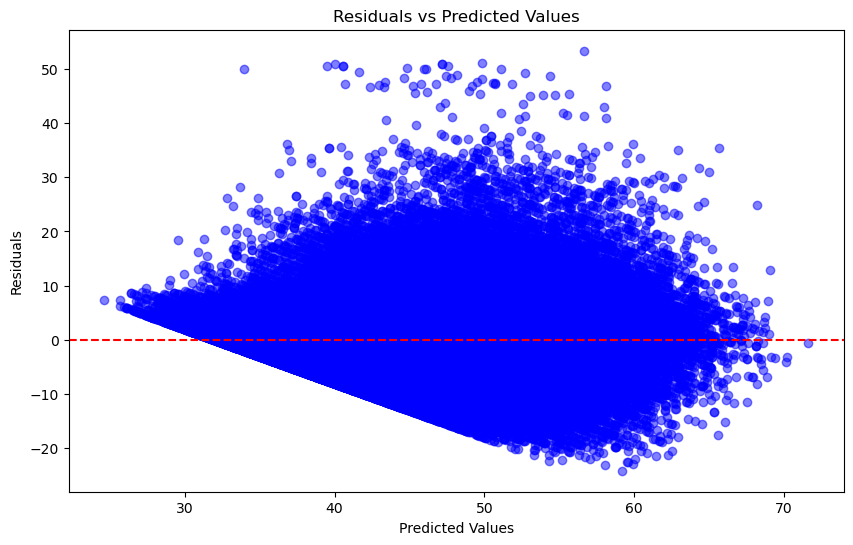

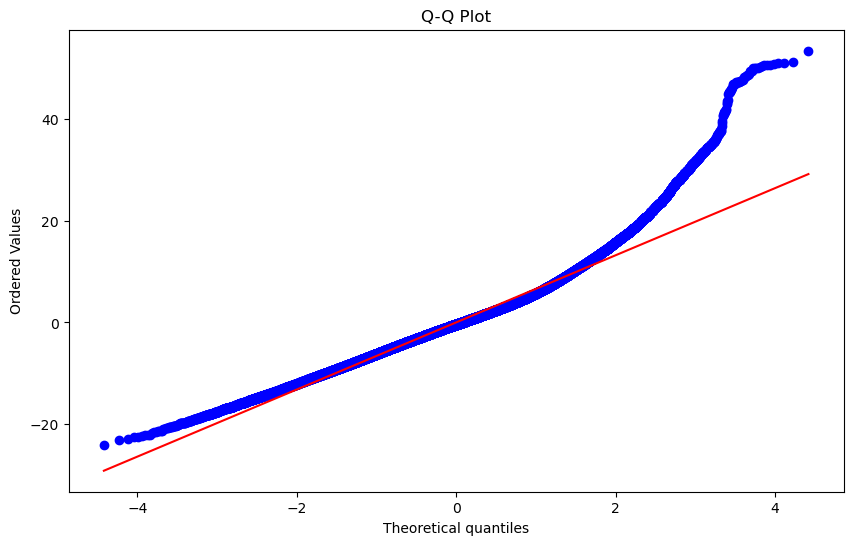

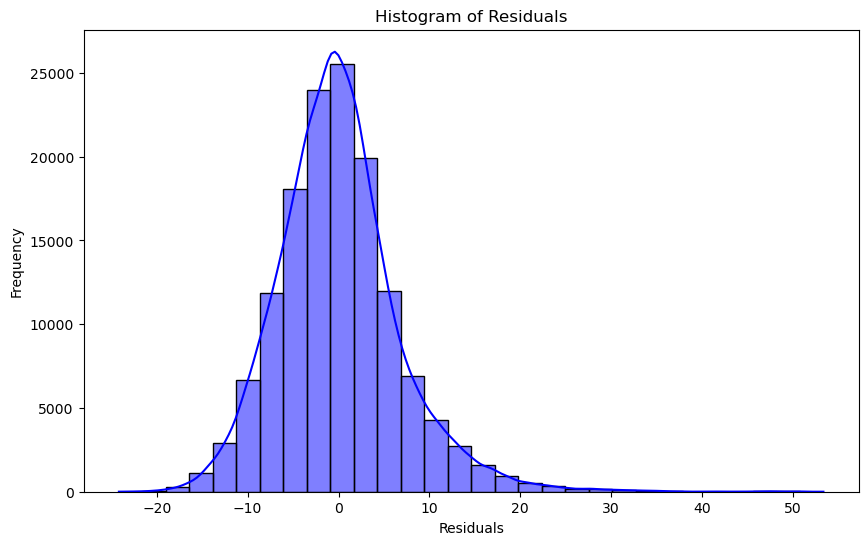

Train: 0.49 Test: 0.5


In [567]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

# Calculate residuals
y_pred = res6.predict(X_train_sm)  # Predicted values
y_pred = pd.Series(y_pred).reset_index(drop=True)

y_train = pd.Series(y_train).reset_index(drop=True)

residuals = y_train - y_pred  # Residuals (actual - predicted)

print(f"Shape of y_pred: {y_pred.shape}")
print(f"Shape of residuals: {residuals.shape}")

# Residuals vs Predicted Values plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Q-Q Plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

# Residual Histogram
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue', bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Model Evaluation 
y_train_pred=res6.predict(X_train_sm)
y_test_pred=res6.predict(X_test_sm)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Train:",round(r2_train,2),"Test:",round(r2_test,2))

**Model Evaluation Summary (R² Score)**

Training R² = 0.49
    The model explains 49% of the variation in delivery time in the training data.

Testing R² = 0.50
    The model explains 50% of the variation in unseen data (test set).

#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [572]:
# Compare the scaled vs unscaled features used in the final model

final_features = [col for col in X_train_sm.columns if col != 'const']

# Scaled Coefficients
# res6 is the final model trained on scaled features
scaled_coefs = pd.Series(res6.params.values, index=X_train_sm.columns)
scaled_coefs.name = "Scaled Coefficients"

# Fit Model on Unscaled Features
y_train_aligned = y_train.reset_index(drop=True)

X_train_unscaled = X_train[final_features]
X_train_unscaled_const = sm.add_constant(X_train_unscaled)  # Add constant
X_train_unscaled_const = X_train_unscaled_const.reset_index(drop=True)

model_unscaled = sm.OLS(y_train, X_train_unscaled_const).fit()

unscaled_coefs = pd.Series(model_unscaled.params.values, index=model_unscaled.params.index)
unscaled_coefs.name = "Unscaled Coefficients"

# Compare Coefficients
coef_comparison = pd.concat([scaled_coefs, unscaled_coefs], axis=1)
print(coef_comparison)

                    Scaled Coefficients  Unscaled Coefficients
const                         35.041134              35.041134
num_distinct_items             1.725757               1.725757
distance                       0.488789               0.488789
isWeekend                      2.449446               2.449446
market_id_2.0                 -4.806472              -4.806472
market_id_3.0                 -5.377090              -5.377090
market_id_4.0                 -2.908616              -2.908616
market_id_5.0                 -4.624064              -4.624064
market_id_6.0                 -2.838215              -2.838215
order_protocol_2.0            -0.786162              -0.786162
order_protocol_3.0            -1.435369              -1.435369
order_protocol_4.0            -3.327144              -3.327144
order_protocol_5.0            -2.761628              -2.761628
order_protocol_6.0            -2.120450              -2.120450
hour_1                         0.948358               0

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [575]:
# Analyze the effect of a unit change in a feature, say 'total_items'

# Calculate effect of 1 unit change in each feature
numeric_features = [feat for feat in final_features if feat not in categorical_cols]
feature_stds = X_train[numeric_features].std()

# Filter scaled coefficients to match
scaled_numeric_coefs = scaled_coefs[numeric_features]

# Compute effect of 1 unit change
unit_change_effect = scaled_numeric_coefs / feature_stds
unit_change_effect.name = "Effect of 1 Unit Change"

# Combine with unscaled and scaled coefficients (optional)
coef_comparison = pd.concat([
    scaled_coefs[numeric_features], 
    unscaled_coefs[numeric_features], 
    unit_change_effect
], axis=1)

coef_comparison.columns = ["Scaled Coefficients", "Unscaled Coefficients", "Effect of 1 Unit Change"]
print(coef_comparison.sort_values("Effect of 1 Unit Change", ascending=False))

                    Scaled Coefficients  Unscaled Coefficients  \
hour_3                         4.039311               4.039311   
hour_2                         4.127595               4.127595   
hour_1                         0.948358               0.948358   
num_distinct_items             1.725757               1.725757   
distance                       0.488789               0.488789   
order_protocol_2.0            -0.786162              -0.786162   
order_protocol_3.0            -1.435369              -1.435369   
hour_5                        -1.124125              -1.124125   
order_protocol_5.0            -2.761628              -2.761628   
market_id_4.0                 -2.908616              -2.908616   
hour_19                       -1.861073              -1.861073   
market_id_2.0                 -4.806472              -4.806472   
order_protocol_4.0            -3.327144              -3.327144   
hour_16                       -1.403666              -1.403666   
hour_20   

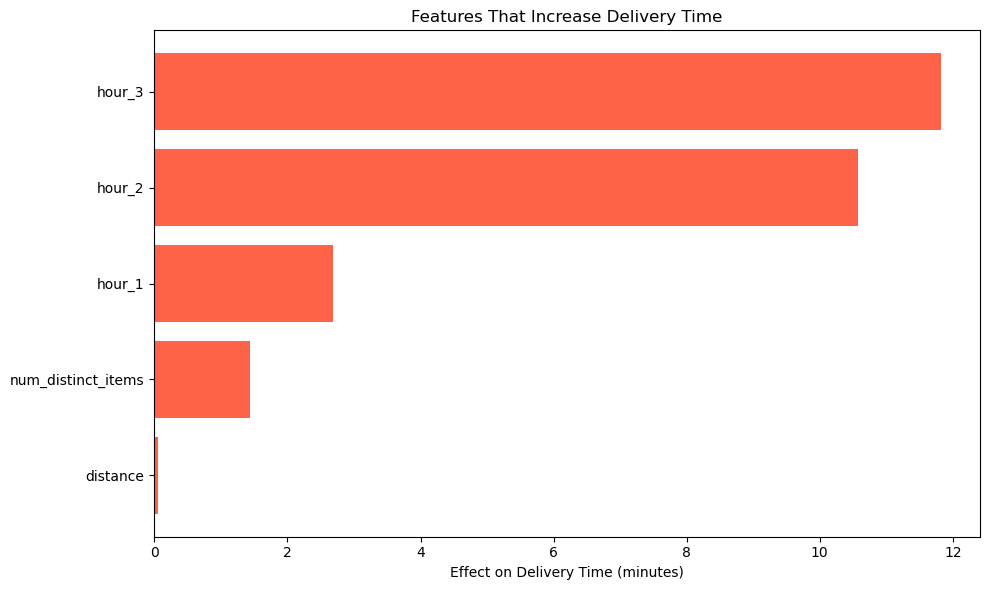

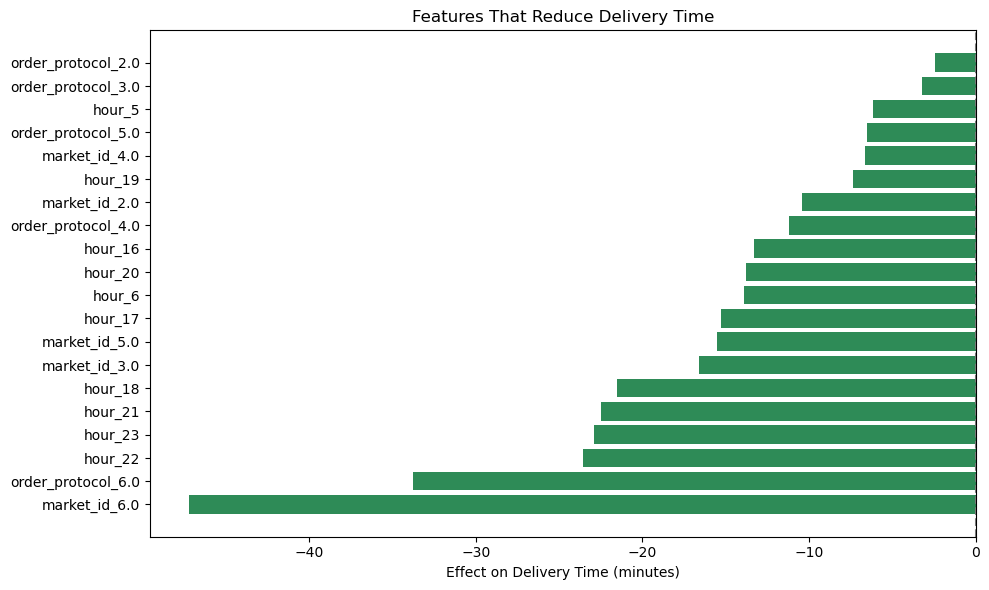

In [577]:
# Analysis on Top 5 Important Features

# Filter features with positive effect (i.e., increase delivery time)
features_increasing_time = coef_comparison[coef_comparison["Effect of 1 Unit Change"] > 0]

# Sort by the effect size
features_increasing_time_sorted = features_increasing_time.sort_values("Effect of 1 Unit Change", ascending=True)

# Plot the results
plt.figure(figsize=(10, 6))
plt.barh(features_increasing_time_sorted.index, features_increasing_time_sorted["Effect of 1 Unit Change"], color='tomato')
plt.xlabel("Effect on Delivery Time (minutes)")
plt.title("Features That Increase Delivery Time")
plt.axvline(x=0, color='grey', linestyle='--')
plt.tight_layout()
plt.show()


# Filter features with negative effect (i.e., reduce delivery time)
features_decreasing_time = coef_comparison[coef_comparison["Effect of 1 Unit Change"] < 0]

# Sort by the effect size (most negative first)
features_decreasing_time_sorted = features_decreasing_time.sort_values("Effect of 1 Unit Change", ascending=True)

# Plot the results
plt.figure(figsize=(10, 6))
plt.barh(features_decreasing_time_sorted.index, features_decreasing_time_sorted["Effect of 1 Unit Change"], color='seagreen')
plt.xlabel("Effect on Delivery Time (minutes)")
plt.title("Features That Reduce Delivery Time")
plt.axvline(x=0, color='grey', linestyle='--')
plt.tight_layout()
plt.show()

Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>

Based on the analysis, the selected categorical variables — **market_id**, **order_protocol**, **isWeekend**, and **hour** — were retained due to their significant impact on delivery time. All other categorical variables were removed as they showed minimal or no contribution to model performance. These retained variables effectively captured regional, procedural, and temporal factors influencing delivery efficiency.


**Inference from Analysis:**

From the analysis, it was observed that these categorical variables had a notable influence on the dependent variable time_taken_minutes:

**market_id:** Different markets showed varying average delivery times, likely due to geography, traffic patterns, or resource availability.

**order_protocol:** Some ordering methods (e.g., protocol 6.0) significantly reduced delivery time, while others increased it, possibly due to order handling efficiency.

**isWeekend:** Weekend orders may reflect different delivery patterns or volume, although its impact was less significant compared to others.

**hour:** Time of day had a strong impact — deliveries placed during early hours (e.g., hour_2 or hour_3) showed higher delivery times, possibly due to fewer dashers or store availability.

---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>

When splitting data into training and test sets using a function like train_test_split, the parameter test_size = 0.2 controls how much of the dataset is set aside for testing.

Specifically:

test_size=0.2 means 20% of the entire dataset will be used as the test set.

The remaining 80% will be used as the training set.

---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>

From the correlation heatmap, the feature with the highest correlation with the target variable time_taken_minutes is:

**distance —** with a correlation coefficient of 0.46

---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>

Outliers were detected in five key numerical features using the Interquartile Range (IQR) method. The percentages of outliers in each column are:

**subtotal:** 4.56% outliers

**num_distinct_items:** 11.92% outliers

**total_outstanding_orders:** 2.96% outliers

**distance:** 0.18% outliers

**time_taken_minutes:** 1.02% outliers

While most columns have less than 5% outliers, num_distinct_items has a slightly higher rate at nearly 12%.

#### The following methods were applied to handle outliers in the columns mentioned above:

**distance:** Removed outliers using IQR (few outliers, safe to drop).

**total_outstanding_orders:** Capped at 95th percentile to reduce high-end impact.

**subtotal:** Capped at 95th percentile to control extreme values.

**num_distinct_items:** Capped using IQR to handle discrete outliers.

Although **time_taken_minutes** contains a small proportion of outliers (1.02%), these were not capped or removed. In regression tasks, especially with real-world delivery data, such outliers often represent genuine long delivery times rather than data errors.

Modifying the target variable can:

1. Distort meaningful variation.
2. Reduce the model's ability to predict rare but important cases.


Hence, the target variable was left unchanged, unless further analysis reveals these outliers are due to anomalies or data quality issues.











---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>

#### Based on the effect of a 1-unit change, the top 3 features that significantly reduced delivery time (i.e., had the most negative impact) are:

**market_id_6.0:** Decreased delivery time by approximately 47.44 minutes.

**order_protocol_6.0:** Decreased delivery time by around 33.03 minutes.

**hour_22:** Decreased delivery time by about 23.57 minutes.

These values were calculated by scaling model coefficients back to real-world units, offering a practical interpretation of each feature’s effect on delivery time.



#### Based on the effect of a 1-unit change, the top 3 features that significantly increased delivery time are:

**hour_3:** Increased delivery time by approximately 11.82 minutes.

**hour_2:** Increased delivery time by around 10.57 minutes.

**hour_1:** Increased delivery time by about 2.70 minutes.

These results show that deliveries placed during early morning hours (1 AM to 3 AM) tend to take longer, possibly due to limited availability of delivery partners or restaurants.

---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>


Linear Regression is a supervised learning algorithm used for predicting a continuous output (dependent variable) based on one or more input features (independent variables).

It finds a linear equation that best describes the correlation of the explanatory variables with the dependent variable. This is achieved by fitting a line to the data using least squares. The line tries to minimize the sum of the squares of the residuals. The residual is the distance between the line and the actual value of the explanatory variable. Finding the line of best fit is an iterative process.

The following is an example of a resulting linear regression equation:
    y=β0+β1x1+β2x2+⋯+βnxn+ϵ

In the example above, y is the dependent variable, and x1, x2, and so on, are the explanatory variables. The coefficients (b1, b2, and so on) explain the correlation of the explanatory variables with the dependent variable. The sign of the coefficients (+/-) designates whether the variable is positively or negatively correlated. b0 is the intercept that indicates the value of the dependent variable assuming all explanatory variables are 0.

In the following image, a linear regression model is described by the regression line y = 153.21 + 900.39x. The model describes the relationship between the dependent variable, Diabetes pregression, and the explanatory variable, Serum triglycerides level. A positive correlation is shown. This example demonstrates a linear regression model with two variables. Although it is not possible to visualize models with more than three variables, practically, a model can have any number of variables.

![Alt Text](linear-regression.png)

A linear regression model helps in predicting the value of a dependent variable, and it can also help explain how accurate the prediction is. This is denoted by the R-squared and p-value values. The R-squared value indicates how much of the variation in the dependent variable can be explained by the explanatory variable and the p-value explains how reliable that explanation is. The R-squared values range between 0 and 1. A value of 0.8 means that the explanatory variable can explain 80 percent of the variation in the observed values of the dependent variable. A value of 1 means that a perfect prediction can be made, which is rare in practice. A value of 0 means the explanatory variable doesn't help at all in predicting the dependent variable. Using a p-value, you can test whether the explanatory variable's effect on the dependent variable is significantly different from 0.

---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>

**Simple Linear Regression:**
1. Involves only one independent variable (predictor).

2. Models the relationship between one feature and the target (dependent) variable.

3. The relationship is represented by a straight line (in 2D space).

    Equation format:

    y=β0+β1x+ϵ

4. Easier to visualize (just a line on a 2D plot).

5. Simpler to compute and interpret.

6. Example: Predicting salary based on years of experience alone.




**Multiple Linear Regression:**
1. Involves two or more independent variables (predictors).

2. Models the relationship between multiple features and the target variable.

3. The relationship is represented by a hyperplane (in higher dimensions).

    Equation format:

    y=β0+β1x1+β2x2+⋯+βnxn+ϵ
    
4. Harder to visualize beyond 3 dimensions.

5. More complex to compute and interpret.

6. Example: Predicting house price based on area, number of bedrooms, and location together.

---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>


In linear regression, the cost function (also called the loss function or objective function) plays a critical role in helping us find the best-fitting line for the data.

The cost function quantifies how well the model's predictions match the actual data. It measures the error or difference between the predicted values (from the linear model) and the actual observed values (from the dataset).

**Common Cost Function: Mean Squared Error (MSE)**

MSE is the average of the squared differences between the actual values and the predicted values. It penalizes large errors more heavily due to the squaring term.


The goal of linear regression is to minimize the cost function (MSE) in order to find the optimal model parameters (i.e., the coefficients 𝛽0,β0,β1,etc.) that result in the best-fitting line.

There are two primary methods to minimize the cost function:

1. Gradient Descent

        Gradient Descent is an optimization algorithm that iteratively adjusts the model parameters to minimize the cost function.

   

3. Normal Equation

        The Normal Equation is an analytical solution to find the optimal parameters without needing an iterative approach like gradient descent.

---

##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.

**Answer:**


**1. Overfitting**

    1. Overfitting happens when a model learns too much from the training data, including noise and random fluctuations.

    2. Performs very well on the training data.

    3. Performs poorly on unseen (test/validation) data.

    4. Model is too complex (too many parameters, too flexible).

    5. Model tries to capture every small detail in the training data.

    6. Very low error on training data.

    7. High error on validation/test data.

    8. Example: A model trying to perfectly predict every data point with a very wiggly curve.


**2. Underfitting**

    1. Underfitting happens when a model is too simple to capture the patterns in the data.
    
    2. Performs poorly on both training data and test data.
    
    3. Model is not complex enough.
    
    4. Model cannot even learn the underlying structure of the data.
    
    5. High error on training data.
    
    6. High error on validation/test data.
    
    7. Example: A straight line trying to fit data that clearly has a curve.
---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**

A residual plot shows residuals on the y-axis and predicted values (or feature values) on the x-axis.
It helps check whether the assumptions of linear regression are valid.

**How Residual Plots Help:**

1. Checking Linearity Assumption:

    Linear regression assumes a linear relationship between the predictors and the target variable.
    
    In a residual plot, if residuals are randomly scattered around the horizontal axis (y=0), it suggests that the linear relationship is appropriate.
    
    If a pattern (like a curve or U-shape) is visible, it indicates that the relationship is non-linear, and the model may be missing important non-linear effects.

2. Checking Homoscedasticity (Constant Variance of Errors):

    Another assumption is that residuals have constant variance across all levels of the independent variables (homoscedasticity).
    
    In the plot, residuals should be spread out evenly across all predicted values.
    
    If residuals fan out (wider spread) or narrow down, it suggests heteroscedasticity, which can affect model performance and validity.

3. Identifying Independence of Errors:

    Residuals should be independent of each other.
    
    Patterns like systematic increases or decreases in residuals suggest autocorrelation or dependent errors, which violates the independence assumption.

4. Detecting Outliers:

    Points with very large residuals (far from zero) are outliers.
    
    Outliers can heavily influence the model and may require special treatment (like removal or robust regression).

5. Assessing Normality of Errors (if needed):

    While not mandatory for fitting the model, the residuals are often assumed to be normally distributed for inference (like hypothesis testing).
    
    Although this is usually checked with a histogram or Q-Q plot, unusual patterns in the residual plot can hint at non-normal errors.


**Ideally, residuals should be randomly distributed around zero without patterns or trends.**